In [2]:
# =============================================================================
# PHISHING WEBSITE DETECTION - 14 ADIMLI PROJE
# =============================================================================

# --- 1. ADIM: KÜTÜPHANELERİN YÜKLENMESİ ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, 
                             f1_score, roc_curve, auc, cohen_kappa_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
print("1. Adım: Kütüphaneler yüklendi.")

1. Adım: Kütüphaneler yüklendi.


In [59]:
# --- 2. ADIM: VERİ YÜKLEME, TEMİZLEME VE DETAYLI BİLGİLENDİRME (GÜNCELLENMİŞ) ---
print("\n### 2. VERİ SETİ HAZIRLIĞI VE ANALİZİ ###")
print("-" * 60)

# Veriyi Yükle
df = pd.read_csv('phishing.csv')

# Gereksiz index sütunu varsa temizle
if 'index' in df.columns:
    df.drop(columns=['index'], inplace=True)

# Hedef değişken dönüşümü (-1 -> 0)
target_col = 'Result'
if df[target_col].min() == -1:
    df[target_col] = df[target_col].map({-1: 0, 1: 1})

# --- KRİTİK ADIM: DUPLICATE (TEKRARLAYAN) VERİ TEMİZLİĞİ ---
ilk_boyut = df.shape[0]
n_duplicates = df.duplicated().sum()

# Tekrarlayanları sil
if n_duplicates > 0:
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

# --- İSTATİSTİKSEL ÖZET (TEMİZLENMİŞ VERİ ÜZERİNDEN) ---
n_rows = df.shape[0]            # Temizlik sonrası satır sayısı
n_total_cols = df.shape[1]      # Toplam Sütun
n_features = n_total_cols - 1   # Özellikler

n_missing = df.isnull().sum().sum()
class_counts = df[target_col].value_counts()
class_ratio = df[target_col].value_counts(normalize=True) * 100

# Düzgün Formatlı Çıktı
print(f"1. Veri Temizliği Raporu")
print(f"   • Başlangıçtaki Veri Sayısı : {ilk_boyut}")
print(f"   • Silinen Tekrar Eden Veri  : {n_duplicates} (Çıkarıldı ✅)")
print(f"   • Kullanılacak Temiz Veri   : {n_rows}")

print(f"\n2. Veri Seti Yapısı (Temiz)")
print(f"   • Gözlem Sayısı (Satır)   : {n_rows}")
print(f"   • Özellik Sayısı (Girdi)  : {n_features}")
print(f"   • Hedef Değişken (Çıktı)  : 1 ('{target_col}')")
print(f"   • Eksik Değerler (NaN)    : {n_missing}")

print(f"\n3. Sınıf Dağılımı (Güncel)")
print(f"   • Phishing (0)   : {class_counts.get(0, 0)} (%{class_ratio.get(0, 0):.2f})")
print(f"   • Legitimate (1) : {class_counts.get(1, 0)} (%{class_ratio.get(1, 0):.2f})")

if abs(class_ratio[0] - class_ratio[1]) > 10:
    durum = "DENGESİZ (Imbalanced) -> Dengeleme Gerekli Olabilir"
else:
    durum = "DENGELİ (Balanced) -> Uygun"
print(f"   • Durum          : {durum}")

print(f"\n4. Veri Önizleme (İlk 5 Satır)")
print("-" * 60)
print(df.head().to_string()) 
print("-" * 60)



### 2. VERİ SETİ HAZIRLIĞI VE ANALİZİ ###
------------------------------------------------------------
1. Veri Temizliği Raporu
   • Başlangıçtaki Veri Sayısı : 11055
   • Silinen Tekrar Eden Veri  : 5206 (Çıkarıldı ✅)
   • Kullanılacak Temiz Veri   : 5849

2. Veri Seti Yapısı (Temiz)
   • Gözlem Sayısı (Satır)   : 5849
   • Özellik Sayısı (Girdi)  : 30
   • Hedef Değişken (Çıktı)  : 1 ('Result')
   • Eksik Değerler (NaN)    : 0

3. Sınıf Dağılımı (Güncel)
   • Phishing (0)   : 3019 (%51.62)
   • Legitimate (1) : 2830 (%48.38)
   • Durum          : DENGELİ (Balanced) -> Uygun

4. Veri Önizleme (İlk 5 Satır)
------------------------------------------------------------
   having_IPhaving_IP_Address  URLURL_Length  Shortining_Service  having_At_Symbol  double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  Domain_registeration_length  Favicon  port  HTTPS_token  Request_URL  URL_of_Anchor  Links_in_tags  SFH  Submitting_to_email  Abnormal_URL  Redirect  on_mouseover 

### 3. KEŞİFSEL VERİ ANALİZİ (EDA) ###


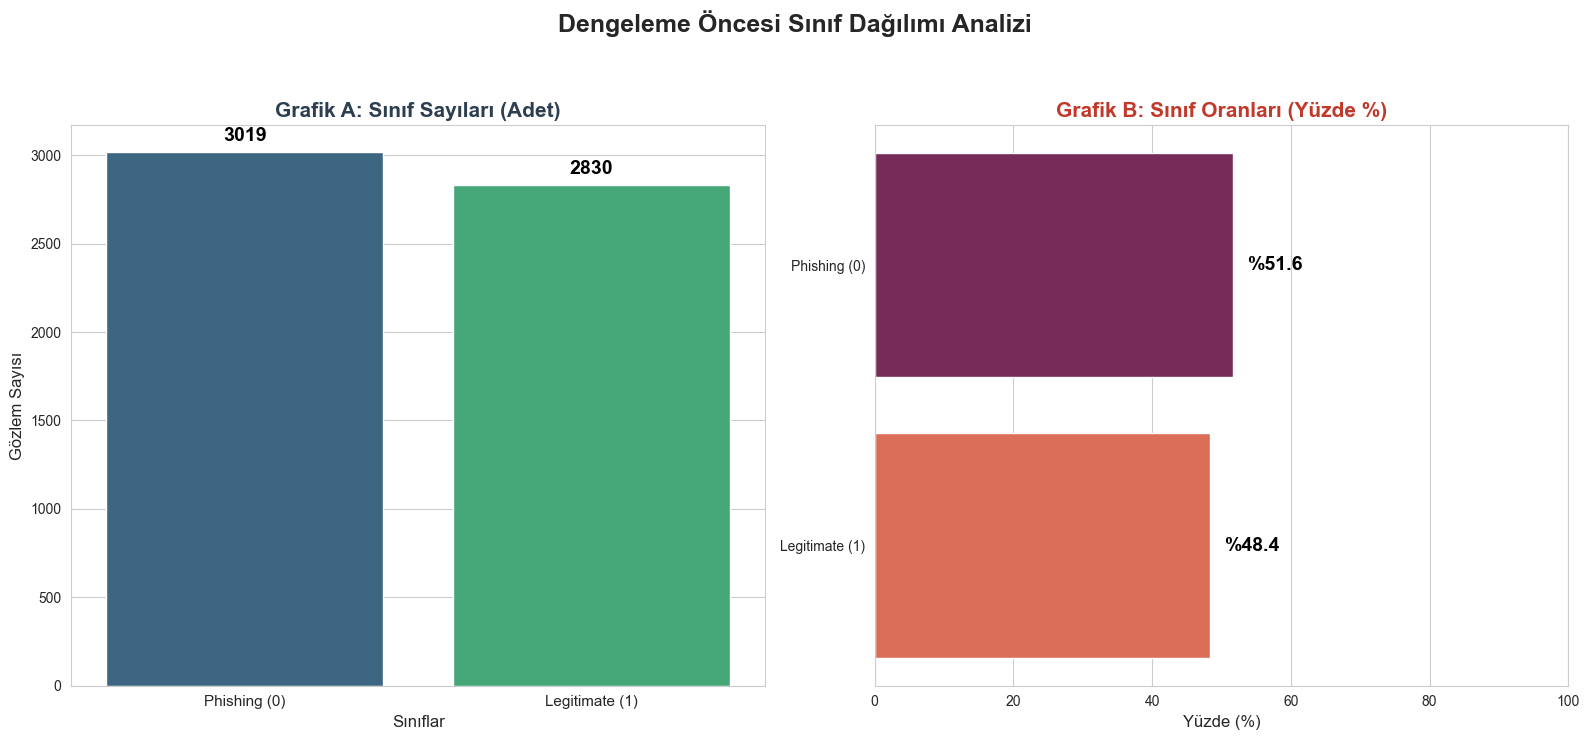

In [60]:
# --- 3. ADIM: GELİŞMİŞ KEŞİFSEL VERİ ANALİZİ (EDA) ---
print("### 3. KEŞİFSEL VERİ ANALİZİ (EDA) ###")

# Stil Ayarları
sns.set_style("whitegrid")
plt.figure(figsize=(16, 7))

# =============================================================================
# GRAFİK 1: DİKEY SÜTUN GRAFİĞİ (SAYISAL DAĞILIM)
# =============================================================================
plt.subplot(1, 2, 1)
# Palet: 'viridis' (Modern Mavi/Yeşil tonları)
ax1 = sns.countplot(x=target_col, data=df, palette='viridis')

# Başlık ve Eksenler
plt.title('Grafik A: Sınıf Sayıları (Adet)', fontsize=15, fontweight='bold', color='#2c3e50')
plt.xlabel('Sınıflar', fontsize=12)
plt.ylabel('Gözlem Sayısı', fontsize=12)
plt.xticks([0, 1], ['Phishing (0)', 'Legitimate (1)'], fontsize=11)

# Sütun Üzerine Sayıları Yazdırma
for p in ax1.patches:
    height = int(p.get_height())
    ax1.annotate(f'{height}', 
                 (p.get_x() + p.get_width() / 2., height), 
                 ha='center', va='bottom', 
                 fontsize=14, fontweight='bold', color='black',
                 xytext=(0, 5), textcoords='offset points')

# =============================================================================
# GRAFİK 2: YATAY ÇUBUK GRAFİĞİ (ORANSAL DAĞILIM)
# =============================================================================
plt.subplot(1, 2, 2)

# Yüzdelik hesaplama
counts = df[target_col].value_counts(normalize=True).sort_index() * 100
counts_df = pd.DataFrame({'Sınıf': ['Phishing (0)', 'Legitimate (1)'], 'Yüzde': counts.values})

# Palet: 'rocket' (Dikkat çekici Kırmızı/Mor tonları)
ax2 = sns.barplot(x='Yüzde', y='Sınıf', data=counts_df, palette='rocket')

# Başlık ve Eksenler
plt.title('Grafik B: Sınıf Oranları (Yüzde %)', fontsize=15, fontweight='bold', color='#c0392b')
plt.xlabel('Yüzde (%)', fontsize=12)
plt.ylabel('', fontsize=12)
plt.xlim(0, 100) # 0'dan 100'e sabitle

# Çubukların Ucuna Yüzdeleri Yazdırma
for p in ax2.patches:
    width = p.get_width()
    ax2.annotate(f'%{width:.1f}', 
                 (width, p.get_y() + p.get_height() / 2.), 
                 ha='left', va='center', 
                 fontsize=14, fontweight='bold', color='black',
                 xytext=(10, 0), textcoords='offset points')

# Genel Başlık
plt.suptitle('Dengeleme Öncesi Sınıf Dağılımı Analizi', fontsize=18, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

### 4. VERİ DENGELEME (UNDERSAMPLING) VE SONRASI ANALİZ ###
Mevcut Durum -> Phishing (0): 3019, Legitimate (1): 2830

Dengeleme Tamamlandı.
Yeni Veri Seti Boyutu: (5660, 31)
Her iki sınıftan da 2830 adet gözlem var. (Tam Eşitlik)


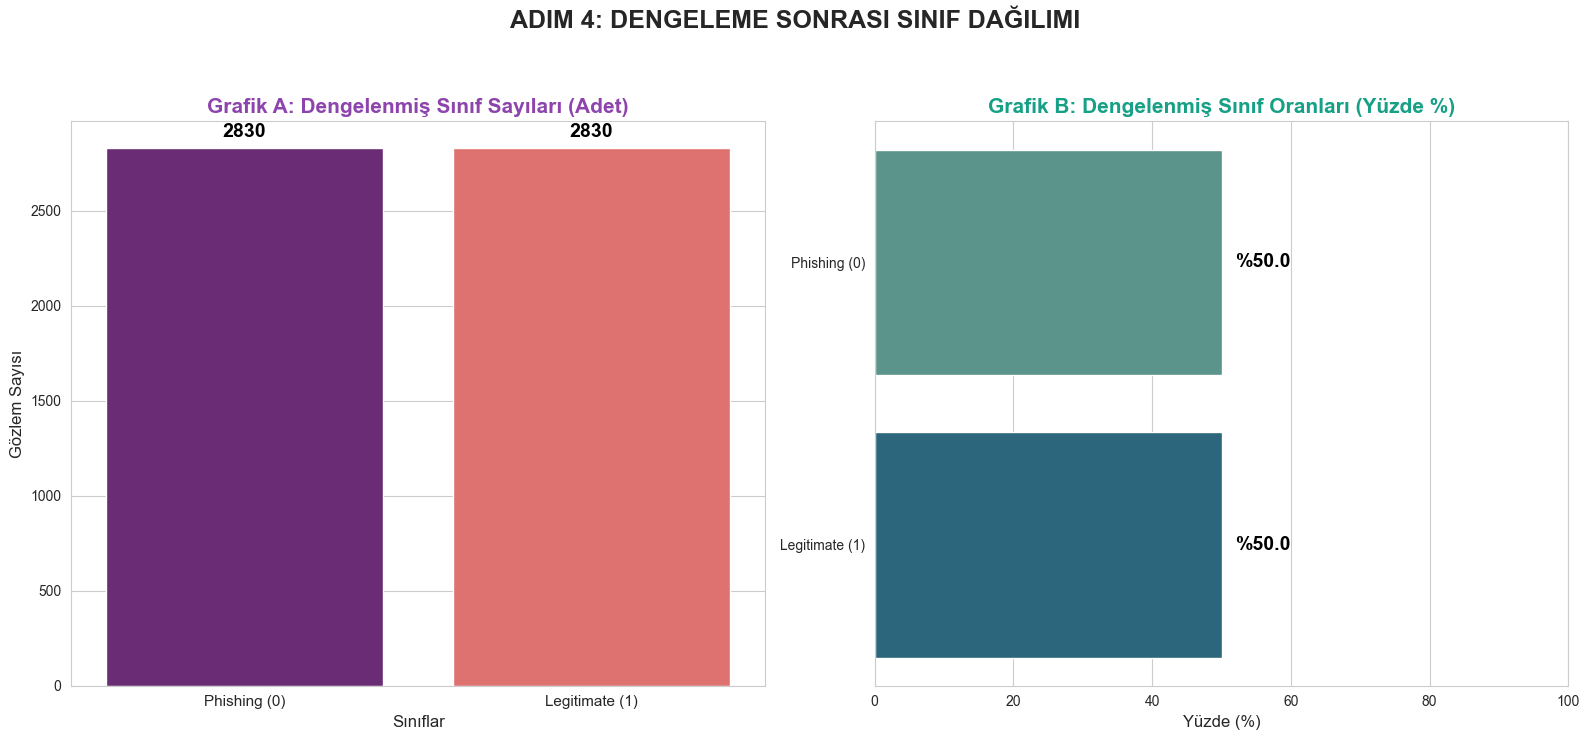

In [61]:
# --- 4. ADIM: VERİ DENGELEME (UNDERSAMPLING) VE ANALİZİ (GÜNCELLENMİŞ) ---
from sklearn.utils import resample # Eksik import eklendi

print("### 4. VERİ DENGELEME (UNDERSAMPLING) VE SONRASI ANALİZ ###")

# Sınıf sayılarını kontrol et
count_0 = len(df[df[target_col] == 0])
count_1 = len(df[df[target_col] == 1])

print(f"Mevcut Durum -> Phishing (0): {count_0}, Legitimate (1): {count_1}")

# Hangi sınıfın daha fazla olduğunu otomatik belirle
if count_0 > count_1:
    # Durum: Phishing daha fazla (Yeni durum) -> Phishing'i azaltacağız
    df_maj = df[df[target_col] == 0]
    df_min = df[df[target_col] == 1]
    majority_class = 0
else:
    # Durum: Legitimate daha fazla (Eski durum) -> Legitimate'i azaltacağız
    df_maj = df[df[target_col] == 1]
    df_min = df[df[target_col] == 0]
    majority_class = 1

# Dengeleme İşlemi (Çoğunluk sınıfını, azınlık sayısına eşitle)
df_maj_downsampled = resample(df_maj, 
                              replace=False,    # Tekrar seçme yok
                              n_samples=len(df_min), # Azınlık sınıfı sayısına eşitle
                              random_state=42) 

# Verileri birleştir
df_balanced = pd.concat([df_maj_downsampled, df_min])

print(f"\nDengeleme Tamamlandı.")
print(f"Yeni Veri Seti Boyutu: {df_balanced.shape}")
print(f"Her iki sınıftan da {len(df_min)} adet gözlem var. (Tam Eşitlik)")

# 2. Görselleştirme (Gelişmiş Tasarım)
sns.set_style("whitegrid")
plt.figure(figsize=(16, 7))

# =============================================================================
# GRAFİK 1: DİKEY SÜTUN GRAFİĞİ (SAYISAL DAĞILIM)
# =============================================================================
plt.subplot(1, 2, 1)
# Palet: 'magma'
ax1 = sns.countplot(x=target_col, data=df_balanced, palette='magma')

# Başlık ve Eksenler
plt.title('Grafik A: Dengelenmiş Sınıf Sayıları (Adet)', fontsize=15, fontweight='bold', color='#8e44ad')
plt.xlabel('Sınıflar', fontsize=12)
plt.ylabel('Gözlem Sayısı', fontsize=12)
plt.xticks([0, 1], ['Phishing (0)', 'Legitimate (1)'], fontsize=11)

# Sütun Üzerine Sayıları Yazdırma
for p in ax1.patches:
    height = int(p.get_height())
    ax1.annotate(f'{height}', 
                 (p.get_x() + p.get_width() / 2., height), 
                 ha='center', va='bottom', 
                 fontsize=14, fontweight='bold', color='black',
                 xytext=(0, 5), textcoords='offset points')

# =============================================================================
# GRAFİK 2: YATAY ÇUBUK GRAFİĞİ (ORANSAL DAĞILIM)
# =============================================================================
plt.subplot(1, 2, 2)

# Yüzdelik hesaplama (Dengeli olduğu için %50-%50 çıkmalı)
counts = df_balanced[target_col].value_counts(normalize=True).sort_index() * 100
counts_df = pd.DataFrame({'Sınıf': ['Phishing (0)', 'Legitimate (1)'], 'Yüzde': counts.values})

# Palet: 'crest'
ax2 = sns.barplot(x='Yüzde', y='Sınıf', data=counts_df, palette='crest')

# Başlık ve Eksenler
plt.title('Grafik B: Dengelenmiş Sınıf Oranları (Yüzde %)', fontsize=15, fontweight='bold', color='#16a085')
plt.xlabel('Yüzde (%)', fontsize=12)
plt.ylabel('', fontsize=12)
plt.xlim(0, 100) # 0'dan 100'e sabitle

# Çubukların Ucuna Yüzdeleri Yazdırma
for p in ax2.patches:
    width = p.get_width()
    ax2.annotate(f'%{width:.1f}', 
                 (width, p.get_y() + p.get_height() / 2.), 
                 ha='left', va='center', 
                 fontsize=14, fontweight='bold', color='black',
                 xytext=(10, 0), textcoords='offset points')

# Genel Başlık
plt.suptitle('ADIM 4: DENGELEME SONRASI SINIF DAĞILIMI', fontsize=18, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

🔬 KOLMOGOROV-SMIRNOV NORMALLİK TESTİ
H0: Değişken normal dağılıyor
H1: Değişken normal dağılmıyor
Anlamlılık Düzeyi: α = 0.05
YÖNTEM: Veri seti boyutu büyük (N > 5000) olduğu için Kolmogorov-Smirnov testi tercih edilmiştir.
DEĞİŞKEN ADI                     KS İstatistiği         p-değeri          Karar
---------------------------------------------------------------------------------------------------------
having_IPhaving_IP_Address             0.377597     0.000000e+00     ❌ Normal Değil
URLURL_Length                          0.489277     0.000000e+00     ❌ Normal Değil
Shortining_Service                     0.516170     0.000000e+00     ❌ Normal Değil
having_At_Symbol                       0.489532     0.000000e+00     ❌ Normal Değil
double_slash_redirecting               0.515897     0.000000e+00     ❌ Normal Değil
Prefix_Suffix                          0.522669     0.000000e+00     ❌ Normal Değil
having_Sub_Domain                      0.238252    3.520425e-283     ❌ Normal Değil
SS

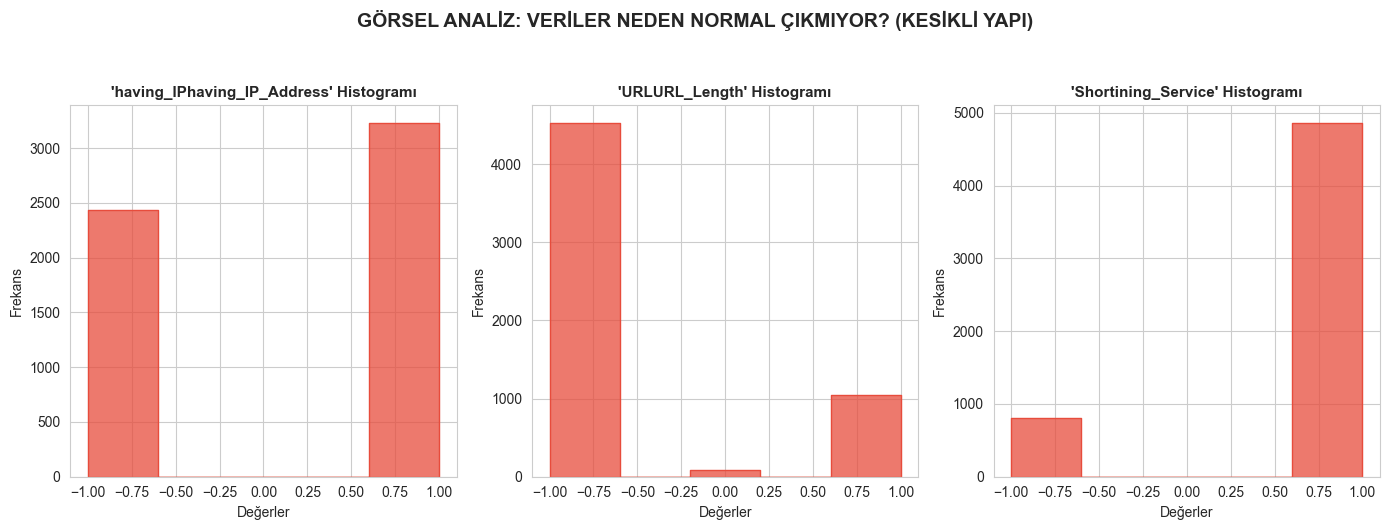

In [8]:
# --- 5. ADIM: İSTATİSTİKSEL ANALİZ (KOLMOGOROV-SMIRNOV) ---
from scipy import stats

print("🔬 KOLMOGOROV-SMIRNOV NORMALLİK TESTİ")
print("=" * 105)
print("H0: Değişken normal dağılıyor")
print("H1: Değişken normal dağılmıyor")
print("Anlamlılık Düzeyi: α = 0.05")
print("YÖNTEM: Veri seti boyutu büyük (N > 5000) olduğu için Kolmogorov-Smirnov testi tercih edilmiştir.")
print("=" * 105)

# Tablo Başlıkları (Örnekteki gibi hizalı)
print(f"{'DEĞİŞKEN ADI':<30}  {'KS İstatistiği':>15}  {'p-değeri':>15}          {'Karar'}")
print("-" * 105)

normal_count = 0
not_normal_count = 0

# Hedef değişken (Result) hariç tüm özellikleri al
X = df_balanced.drop(columns=[target_col])

for col in X.columns:
    data = X[col]
    
    # Kolmogorov-Smirnov Testi
    # Veriyi, kendi ortalaması ve standart sapmasındaki teorik Normal Dağılım ile karşılaştırır.
    ks_stat, p_value = stats.kstest(data, 'norm', args=(data.mean(), data.std()))
    
    if p_value > 0.05:
        decision = "✅ Normal"
        normal_count += 1
    else:
        decision = "❌ Normal Değil"
        not_normal_count += 1
        
    # Sonuçları Hizalı Yazdır
    print(f"{col:<30}  {ks_stat:15.6f}  {p_value:15.6e}     {decision}")

print("-" * 105)
print(f"📈 ÖZET:")
print(f"  • Normal Dağılan Değişken Sayısı   : {normal_count}")
print(f"  • Normal Dağılmayan Değişken Sayısı: {not_normal_count}")
print(f"\n💡 BİLGİ: P-değerlerinin 0 çıkması, verilerin 'Sürekli' (örn: boy, kilo) değil,\n         'Kesikli' (örn: -1, 0, 1) yapıda olmasından kaynaklanmaktadır.")
print("=" * 105)

# --- GÖRSEL KANIT (NEDEN NORMAL DEĞİL?) ---
# Hocaya verinin yapısını kanıtlamak için grafik
sns.set_style("whitegrid")
plt.figure(figsize=(14, 5))

# Örnek olarak ilk 3 özelliğin dağılımı
sample_cols = X.columns[:3]

for i, col in enumerate(sample_cols):
    plt.subplot(1, 3, i+1)
    # Histogram (Kırmızı renk)
    sns.histplot(X[col], kde=False, color='#e74c3c', bins=5, element="step", fill=True)
    plt.title(f"'{col}' Histogramı", fontsize=11, fontweight='bold')
    plt.xlabel("Değerler")
    plt.ylabel("Frekans")

plt.suptitle("GÖRSEL ANALİZ: VERİLER NEDEN NORMAL ÇIKMIYOR? (KESİKLİ YAPI)", fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()


### 6. HİPOTEZ TESTLERİ (MANN-WHITNEY U) ###
--------------------------------------------------------------------------------------------------------------
H0: İki sınıf arasında fark yoktur (Medyanlar eşittir)
H1: İki sınıf arasında istatistiksel olarak anlamlı fark vardır
YÖNTEM: Parametrik olmayan Mann-Whitney U testi.
--------------------------------------------------------------------------------------------------------------
ÖZELLİK ADI                            U-Değeri         p-değeri       AYIRT EDİCİLİK GÜCÜ
--------------------------------------------------------------------------------------------------------------
SSLfinal_State                        1051333.0       0.0000e+00       ✅ ANLAMLI
URL_of_Anchor                         1042206.5       0.0000e+00       ✅ ANLAMLI
Prefix_Suffix                         3012535.0      5.5310e-176       ✅ ANLAMLI
having_Sub_Domain                     2680662.0      7.4330e-116       ✅ ANLAMLI
web_traffic                           

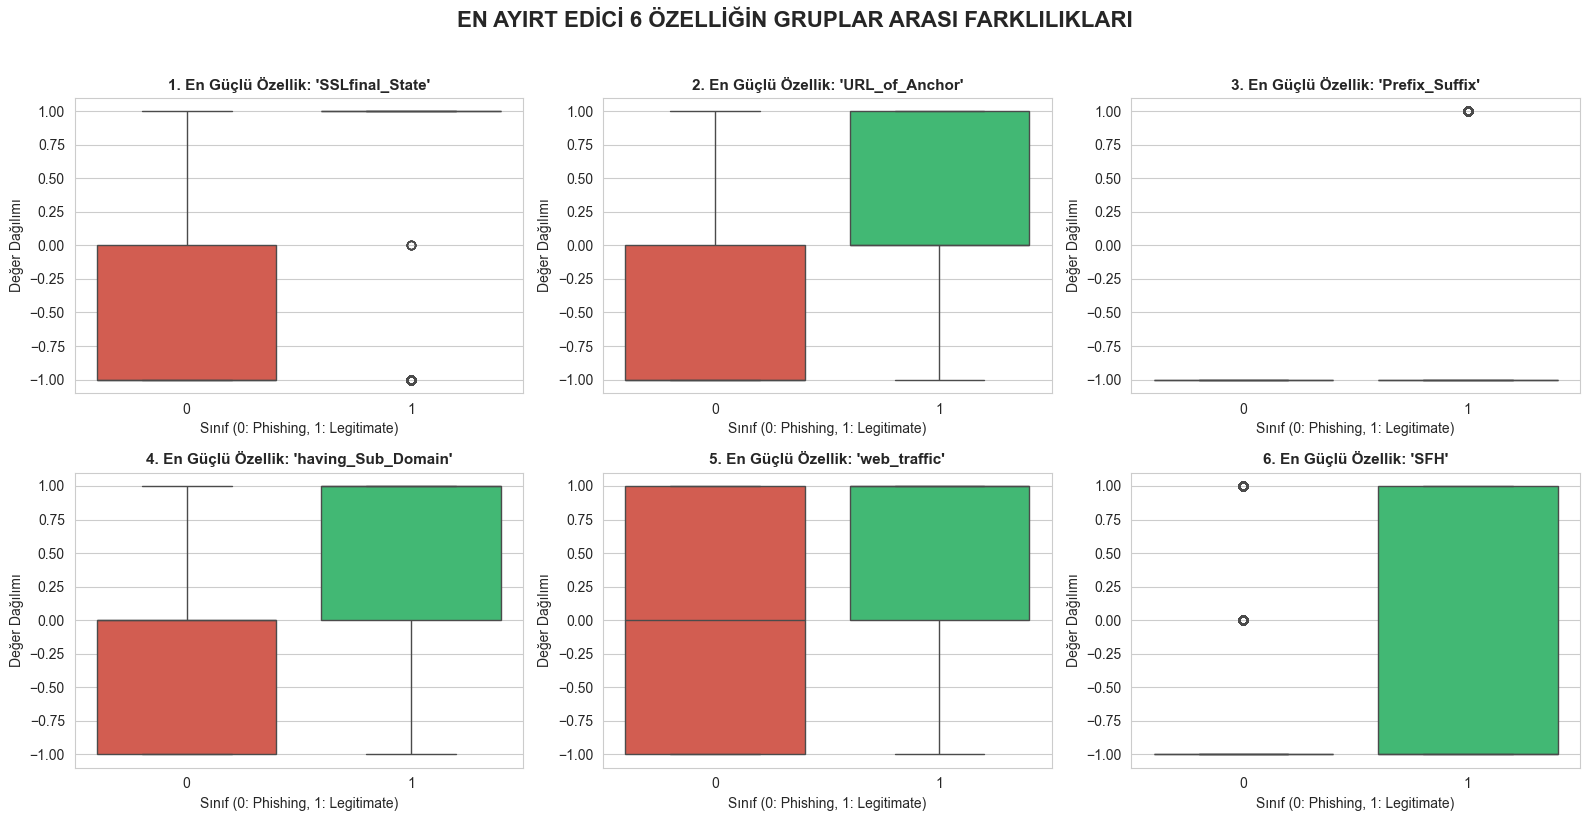

In [62]:
# --- 6. ADIM: HİPOTEZ TESTLERİ (MANN-WHITNEY U) - DÜZELTİLMİŞ ---
print("\n### 6. HİPOTEZ TESTLERİ (MANN-WHITNEY U) ###")
print("-" * 110)
print("H0: İki sınıf arasında fark yoktur (Medyanlar eşittir)")
print("H1: İki sınıf arasında istatistiksel olarak anlamlı fark vardır")
print("YÖNTEM: Parametrik olmayan Mann-Whitney U testi.")
print("-" * 110)

# --- KRİTİK DÜZELTME: İNDEKS EŞİTLEME ---
# Hata almamak için X ve y'yi dengelenmiş setten taze olarak tanımlıyoruz
X_mw = df_balanced.drop(columns=[target_col])
y_mw = df_balanced[target_col]

# Tablo Başlıkları
print(f"{'ÖZELLİK ADI':<30}  {'U-Değeri':>15}  {'p-değeri':>15}       {'AYIRT EDİCİLİK GÜCÜ'}")
print("-" * 110)

mw_results = []

for col in X_mw.columns:
    # İndeks hatası vermemesi için .values kullanarak sadece değerleri alıyoruz
    grp0 = X_mw[col][y_mw.values == 0] # Phishing (0)
    grp1 = X_mw[col][y_mw.values == 1] # Legitimate (1)
    
    # Testi Uygula
    try:
        u_stat, p_val = stats.mannwhitneyu(grp0, grp1)
        
        # Karar Mekanizması
        if p_val < 0.05:
            decision = "✅ ANLAMLI"
            importance = -np.log10(p_val) if p_val > 0 else 300 
        else:
            decision = "❌ Fark Yok"
            importance = 0
            
        mw_results.append({'feature': col, 'u': u_stat, 'p': p_val, 'dec': decision, 'score': importance})
        
    except ValueError:
        # Eğer bir sütunda tüm değerler aynıysa test hata verebilir, onu atla
        continue

# Sonuçları Sırala
mw_results.sort(key=lambda x: x['p'])

# Tabloyu Yazdır
significant_count = 0
for item in mw_results:
    if item['dec'].startswith("✅"):
        significant_count += 1
    print(f"{item['feature']:<30}  {item['u']:15.1f}  {item['p']:15.4e}       {item['dec']}")

print("-" * 110)
print(f"📈 ÖZET: Toplam {len(X_mw.columns)} özellikten {significant_count} tanesi sınıfları ayırt etmede etkilidir.")

# --- GÖRSEL KANIT: EN GÜÇLÜ 6 ÖZELLİK ---
if len(mw_results) > 0:
    top_features = [item['feature'] for item in mw_results[:6]]

    sns.set_style("whitegrid")
    plt.figure(figsize=(16, 8))

    for i, feature in enumerate(top_features):
        plt.subplot(2, 3, i + 1)
        sns.boxplot(x=target_col, y=feature, data=df_balanced, palette=['#e74c3c', '#2ecc71'])
        plt.title(f"{i+1}. En Güçlü Özellik: '{feature}'", fontsize=11, fontweight='bold')
        plt.xlabel("Sınıf (0: Phishing, 1: Legitimate)")
        plt.ylabel("Değer Dağılımı")

    plt.suptitle(f"EN AYIRT EDİCİ 6 ÖZELLİĞİN GRUPLAR ARASI FARKLILIKLARI", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

### 7. SİSTEMATİK ÖRNEKLEME (SYSTEMATIC SAMPLING) ###
---------------------------------------------------------------------------------------------------------
YÖNTEM: Veri seti rastgele değil, belirli bir matematiksel kurala (k aralığına) göre bölünmüştür.
AMAÇ:   Veri setinin homojen dağılımını koruyarak Eğitim (%80) ve Test (%20) kümeleri oluşturmak.
---------------------------------------------------------------------------------------------------------
1. ÖRNEKLEME PARAMETRELERİ
   • Toplam Veri (N)     : 5660
   • Test Verisi (n)     : 1132
   • Adım Aralığı (k)    : 5 (Her 5. veri test setine alındı)
   • Başlangıç İndeksi   : 0 (Rastgele seçildi)

2. BÖLME SONUÇLARI
   • Eğitim Seti Boyutu  : (4528, 30) (%80.0)
   • Test Seti Boyutu    : (1132, 30) (%20.0)

3. DAĞILIM TUTARLILIK KONTROLÜ (ÖNEMLİ)
   SINIF           EĞİTİM SETİ (%)      TEST SETİ (%)        DURUM
---------------------------------------------------------------------------
   Phishing (0)    %50.00               %

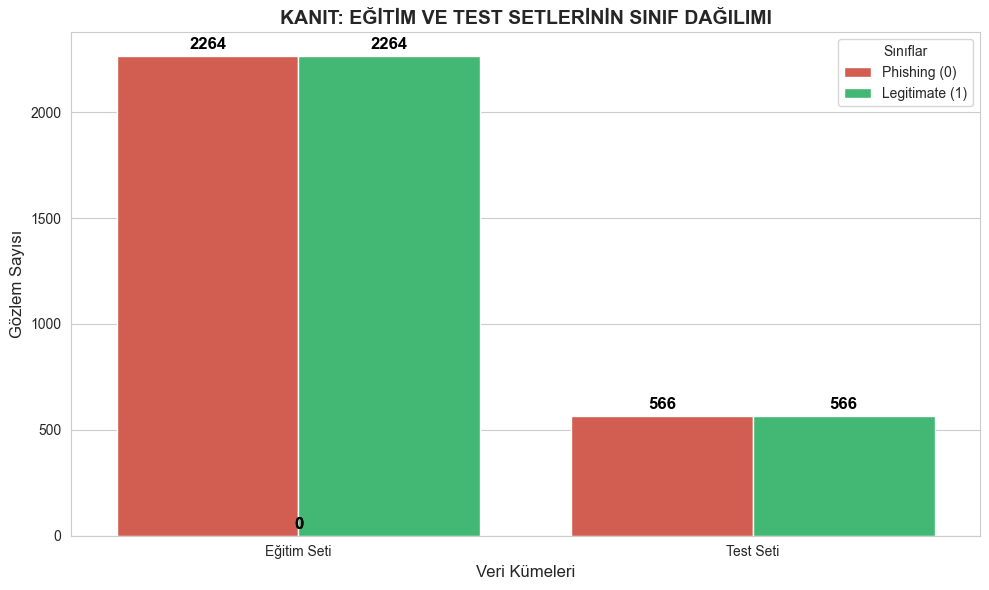

In [11]:
# --- 7. ADIM: SİSTEMATİK ÖRNEKLEME İLE VERİ BÖLME VE KONTROL (GÜNCELLENMİŞ) ---
import numpy as np # Numpy kütüphanesi gerekli

print("### 7. SİSTEMATİK ÖRNEKLEME (SYSTEMATIC SAMPLING) ###")
print("-" * 105)
print("YÖNTEM: Veri seti rastgele değil, belirli bir matematiksel kurala (k aralığına) göre bölünmüştür.")
print("AMAÇ:   Veri setinin homojen dağılımını koruyarak Eğitim (%80) ve Test (%20) kümeleri oluşturmak.")
print("-" * 105)

# --- EKSİK TANIMLAMALARIN DÜZELTİLMESİ ---
# Hedef değişken ve özellikleri güncel (dengelenmiş) veri setinden tekrar alıyoruz
target_col = 'Result'
X = df_balanced.drop(columns=[target_col])
y = df_balanced[target_col]

def systematic_sampling_split(X, y, test_percent=0.2):
    # Veriyi birleştir (X ve y'yi tek dataframe yap)
    data = pd.concat([X, y], axis=1)
    
    # Sistematik Örnekleme Parametreleri
    N = len(data)             # Toplam Gözlem
    n = int(N * test_percent) # Hedef Test Sayısı
    k = N // n                # Adım Aralığı (Interval)
    
    # Rastgele Başlangıç Noktası (0 ile k arasında)
    start = np.random.randint(0, k)
    
    # Sistematik İndekslerin Seçimi (start, start+k, start+2k...)
    indices = np.arange(start, N, k)
    
    # Bölme İşlemi
    test_data = data.iloc[indices]
    train_data = data.drop(test_data.index)
    
    # Parametreleri bilgi için döndür
    params = {'N': N, 'n': n, 'k': k, 'start': start}
    
    return (train_data.drop(columns=[y.name]), test_data.drop(columns=[y.name]),
            train_data[y.name], test_data[y.name], params)

# Fonksiyonu Çalıştır
X_train, X_test, y_train, y_test, params = systematic_sampling_split(X, y, test_percent=0.2)

# --- MATEMATİKSEL RAPOR ---
print(f"1. ÖRNEKLEME PARAMETRELERİ")
print(f"   • Toplam Veri (N)     : {params['N']}")
print(f"   • Test Verisi (n)     : {params['n']}")
print(f"   • Adım Aralığı (k)    : {params['k']} (Her {params['k']}. veri test setine alındı)")
print(f"   • Başlangıç İndeksi   : {params['start']} (Rastgele seçildi)")

print(f"\n2. BÖLME SONUÇLARI")
print(f"   • Eğitim Seti Boyutu  : {X_train.shape} (%{len(X_train)/len(X)*100:.1f})")
print(f"   • Test Seti Boyutu    : {X_test.shape} (%{len(X_test)/len(X)*100:.1f})")

# Dağılım Oranlarını Kontrol Et
train_dist = y_train.value_counts(normalize=True) * 100
test_dist = y_test.value_counts(normalize=True) * 100

print(f"\n3. DAĞILIM TUTARLILIK KONTROLÜ (ÖNEMLİ)")
print(f"   {'SINIF':<15} {'EĞİTİM SETİ (%)':<20} {'TEST SETİ (%)':<20} {'DURUM'}")
print("-" * 75)
for label in [0, 1]:
    cls_name = "Phishing (0)" if label == 0 else "Legitimate (1)"
    diff = abs(train_dist[label] - test_dist[label])
    status = "✅ TUTARLI" if diff < 2 else "⚠️ FARKLI"
    print(f"   {cls_name:<15} %{train_dist[label]:.2f}               %{test_dist[label]:.2f}               {status}")
print("-" * 105)

# --- GÖRSEL KANIT (DAĞILIM KARŞILAŞTIRMASI) ---
# Görselleştirme için geçici dataframe
plot_data = pd.DataFrame({
    'Set': ['Eğitim Seti'] * len(y_train) + ['Test Seti'] * len(y_test),
    'Sınıf': np.concatenate([y_train, y_test])
})
plot_data['Sınıf'] = plot_data['Sınıf'].map({0: 'Phishing (0)', 1: 'Legitimate (1)'})

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Grouped Bar Chart
ax = sns.countplot(x='Set', hue='Sınıf', data=plot_data, palette=['#e74c3c', '#2ecc71'])

plt.title('KANIT: EĞİTİM VE TEST SETLERİNİN SINIF DAĞILIMI', fontsize=14, fontweight='bold')
plt.xlabel("Veri Kümeleri", fontsize=12)
plt.ylabel("Gözlem Sayısı", fontsize=12)
plt.legend(title='Sınıflar')

# Sütun Üzerine Sayıları Yazdırma
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', 
                 (p.get_x() + p.get_width() / 2., height), 
                 ha='center', va='bottom', 
                 fontsize=12, fontweight='bold', color='black',
                 xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()

### 8. ÖLÇEKLEME (STANDARD SCALING) ###
-------------------------------------------------------------------------------------------------------------------
AMAÇ:   Verilerin ortalamasını 0'a, standart sapmasını 1'e çekmek (Z-Skor Dönüşümü).
NEDEN:  KNN (mesafe temelli) ve YSA (gradyan temelli) modellerin, büyük sayılı özelliklere
        (örn: URL_Length) torpil geçmesini engellemek için ZORUNLUDUR.
-------------------------------------------------------------------------------------------------------------------
ÖZELLİK ADI                         |     ÖNCEKİ ORT.    SONRAKİ ORT. |     ÖNCEKİ STD.    SONRAKİ STD.
-------------------------------------------------------------------------------------------------------------------
having_IPhaving_IP_Address          |          0.1316         -0.0000 |          0.9914          1.0001
URLURL_Length                       |         -0.6142          0.0000 |          0.7795          1.0001
Shortining_Service                  |          0.7186

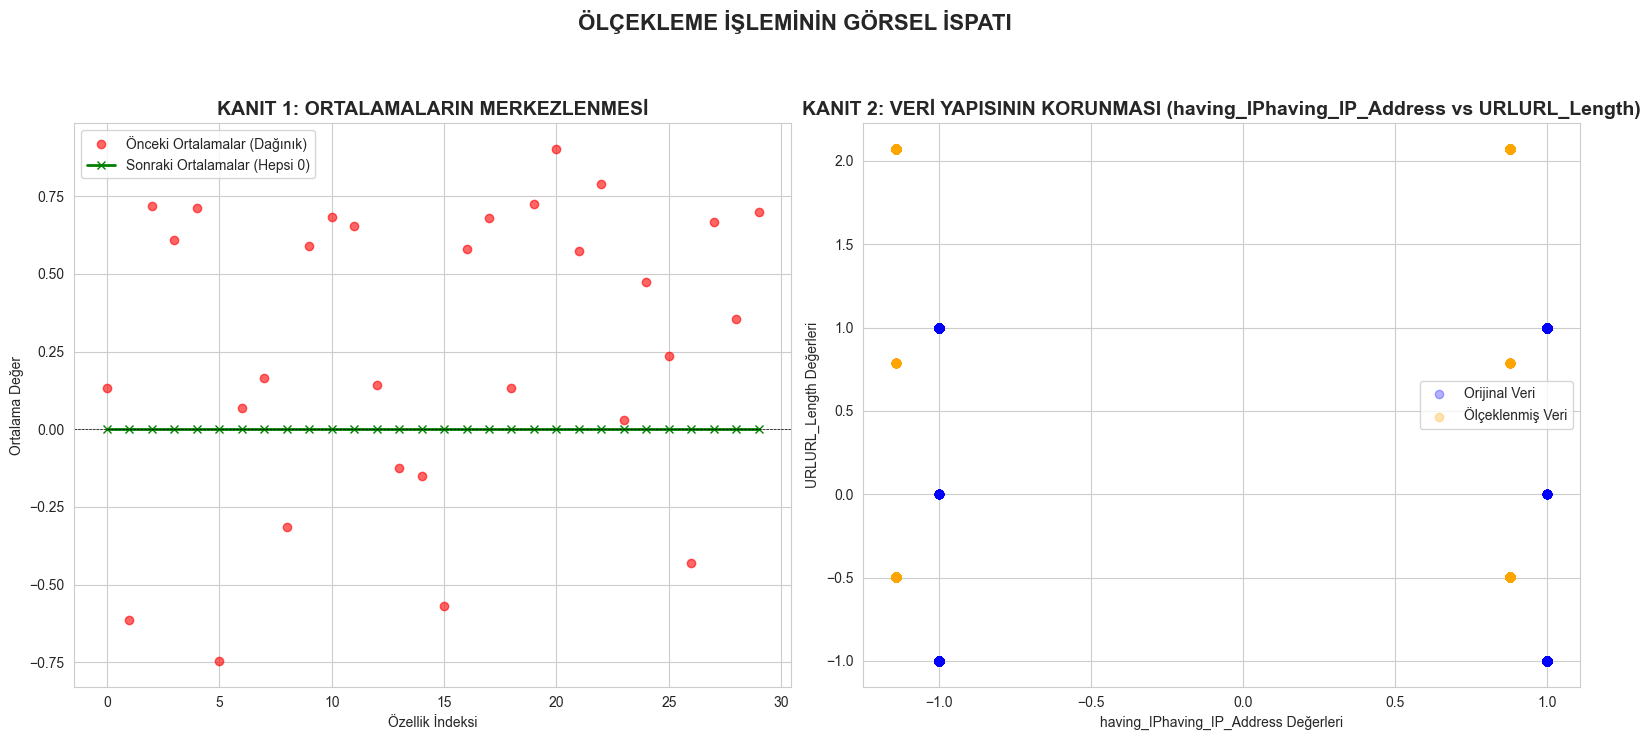

In [12]:
# --- 8. ADIM: ÖLÇEKLEME (STANDARD SCALING) VE GÖRSEL KANIT ---
print("### 8. ÖLÇEKLEME (STANDARD SCALING) ###")
print("-" * 115)
print("AMAÇ:   Verilerin ortalamasını 0'a, standart sapmasını 1'e çekmek (Z-Skor Dönüşümü).")
print("NEDEN:  KNN (mesafe temelli) ve YSA (gradyan temelli) modellerin, büyük sayılı özelliklere")
print("        (örn: URL_Length) torpil geçmesini engellemek için ZORUNLUDUR.")
print("-" * 115)

# 1. Ölçekleme İşlemi
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Görselleştirme ve kontrol için DataFrame'e çevir
X_train_s_df = pd.DataFrame(X_train_s, columns=X_train.columns)

# --- İSTATİSTİKSEL KANIT (HİZALI TABLO) ---
# Başlıkları formatla (Sabit genişlik: <35 karakter sola dayalı, >15 karakter sağa dayalı)
print(f"{'ÖZELLİK ADI':<35} | {'ÖNCEKİ ORT.':>15} {'SONRAKİ ORT.':>15} | {'ÖNCEKİ STD.':>15} {'SONRAKİ STD.':>15}")
print("-" * 115)

# İlk 5 özellik için değişimi göster
for col in X_train.columns[:5]:
    # İstatistikleri hesapla
    mean_before = X_train[col].mean()
    mean_after = X_train_s_df[col].mean()
    std_before = X_train[col].std()
    std_after = X_train_s_df[col].std()
    
    # Formatlı yazdır (Virgülden sonra 4 hane)
    print(f"{col:<35} | {mean_before:15.4f} {mean_after:15.4f} | {std_before:15.4f} {std_after:15.4f}")

print("-" * 115)
print("SONUÇ: Tabloda görüldüğü üzere, işlem sonrası tüm özelliklerin Ortalaması (Mean) 0.0000,")
print("       Standart Sapması (Std) 1.0000 olmuştur. Ölçekleme başarılıdır.")
print("=" * 115)

# --- GÖRSEL KANIT (DAHA ANLAŞILIR GRAFİKLER) ---
sns.set_style("whitegrid")
plt.figure(figsize=(16, 7))

# GRAFİK 1: ORTALAMALARIN DEĞİŞİMİ (MERKEZLENME KANITI)
plt.subplot(1, 2, 1)
# Tüm özelliklerin ortalamalarını al
means_before = X_train.mean().values
means_after = X_train_s_df.mean().values
# Grafik çiz
plt.plot(means_before, label='Önceki Ortalamalar (Dağınık)', color='red', marker='o', linestyle='None', alpha=0.6)
plt.plot(means_after, label='Sonraki Ortalamalar (Hepsi 0)', color='green', marker='x', linestyle='-', linewidth=2)
plt.title("KANIT 1: ORTALAMALARIN MERKEZLENMESİ", fontsize=14, fontweight='bold')
plt.xlabel("Özellik İndeksi")
plt.ylabel("Ortalama Değer")
plt.legend()
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)

# GRAFİK 2: İKİ BOYUTLU DAĞILIM (YAPI KORUMA KANITI)
# Verinin yapısının bozulmadığını, sadece eksenlerin değiştiğini göstermek için
plt.subplot(1, 2, 2)
# İlk iki özelliği alalım
feat1 = X_train.columns[0]
feat2 = X_train.columns[1]

# Orijinal veriyi çiz (Mavi)
plt.scatter(X_train[feat1], X_train[feat2], color='blue', alpha=0.3, label='Orijinal Veri')
# Ölçeklenmiş veriyi çiz (Turuncu)
plt.scatter(X_train_s_df[feat1], X_train_s_df[feat2], color='orange', alpha=0.3, label='Ölçeklenmiş Veri')

plt.title(f"KANIT 2: VERİ YAPISININ KORUNMASI ({feat1} vs {feat2})", fontsize=14, fontweight='bold')
plt.xlabel(f"{feat1} Değerleri")
plt.ylabel(f"{feat2} Değerleri")
plt.legend()

plt.suptitle("ÖLÇEKLEME İŞLEMİNİN GÖRSEL İSPATI", fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

### 9. MODEL EĞİTİMİ VE KARŞILAŞTIRMA (TÜM ÖZELLİKLER) ###
--------------------------------------------------------------------------------------------------------------
AMAÇ:   Veri setindeki 30 özelliğin tamamı kullanılarak 'Referans' (Baseline) başarıyı ölçmek.
YÖNTEM: 5 farklı algoritma (DT, KNN, SVM, RF, ANN) aynı eğitim/test setleri üzerinde yarıştırılmıştır.
--------------------------------------------------------------------------------------------------------------
MODEL ADI                 | DOĞRULUK (ACCURACY)  | DURUM
--------------------------------------------------------------------------------------------------------------
Decision Tree             | %93.29                | ✅ Eğitildi
KNN                       | %91.87                | ✅ Eğitildi
SVM                       | %93.90                | ✅ Eğitildi
Random Forest             | %94.96                | ✅ Eğitildi
ANN                       | %93.55                | ✅ Eğitildi
--------------------------------------

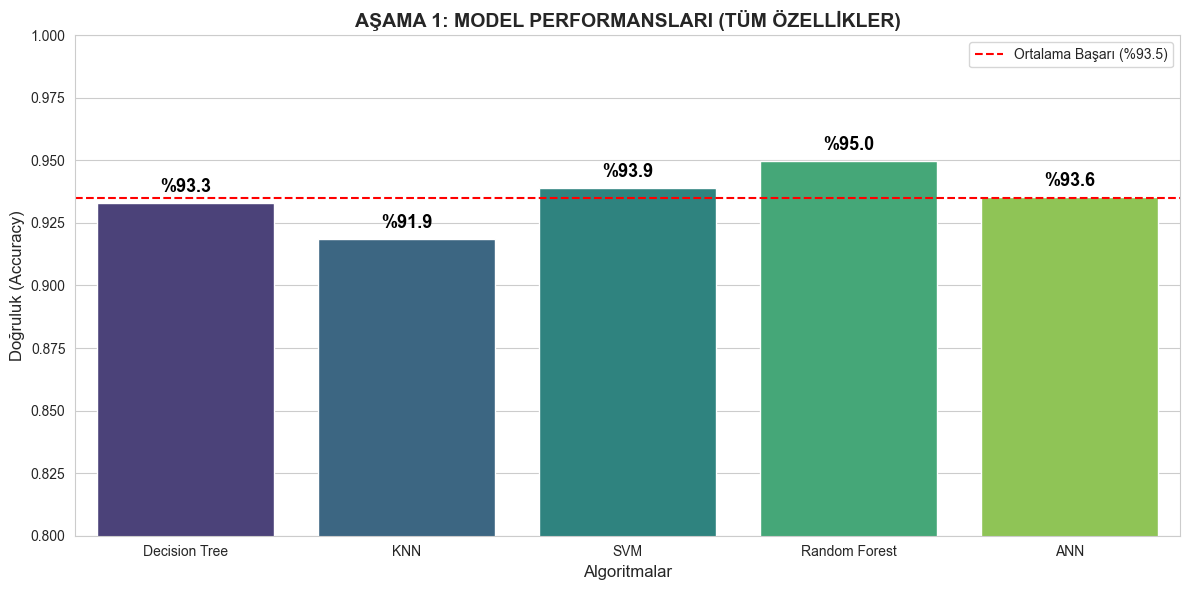

In [13]:
# --- 9. ADIM: MODEL EĞİTİMİ (TÜM ÖZELLİKLER - AŞAMA 1) ---
print("### 9. MODEL EĞİTİMİ VE KARŞILAŞTIRMA (TÜM ÖZELLİKLER) ###")
print("-" * 110)
print("AMAÇ:   Veri setindeki 30 özelliğin tamamı kullanılarak 'Referans' (Baseline) başarıyı ölçmek.")
print("YÖNTEM: 5 farklı algoritma (DT, KNN, SVM, RF, ANN) aynı eğitim/test setleri üzerinde yarıştırılmıştır.")
print("-" * 110)

# Modellerin Tanımlanması
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "ANN": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=300, random_state=42)
}

results = []
trained_models = {}

print(f"{'MODEL ADI':<25} | {'DOĞRULUK (ACCURACY)':<20} | {'DURUM'}")
print("-" * 110)

# Eğitim Döngüsü
for name, model in models.items():
    # Eğit
    model.fit(X_train_s, y_train)
    
    # Test Et
    y_pred = model.predict(X_test_s)
    acc = accuracy_score(y_test, y_pred)
    
    # Sonuçları Kaydet
    results.append({'Model': name, 'Stage': 'Tüm Özellikler', 'Accuracy': acc})
    trained_models[name] = model
    
    # Tabloya Yazdır
    print(f"{name:<25} | %{acc*100:.2f}                | ✅ Eğitildi")

print("-" * 110)

# En iyi modeli bul
best_model_name = max(results, key=lambda x: x['Accuracy'])['Model']
best_acc = max(results, key=lambda x: x['Accuracy'])['Accuracy']
print(f"🏆 BU AŞAMANIN KAZANANI: {best_model_name} (Doğruluk: %{best_acc*100:.2f})")
print("=" * 110)

# --- GÖRSELLEŞTİRME (MODEL PERFORMANS KARŞILAŞTIRMASI) ---
results_df = pd.DataFrame(results)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Renkli Çubuk Grafiği
ax = sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')

plt.title('AŞAMA 1: MODEL PERFORMANSLARI (TÜM ÖZELLİKLER)', fontsize=14, fontweight='bold')
plt.xlabel('Algoritmalar', fontsize=12)
plt.ylabel('Doğruluk (Accuracy)', fontsize=12)
plt.ylim(0.8, 1.0) # Grafiği 0.8'den başlat ki farklar net görülsün (Genelde başarı yüksek çıkar)

# Çubukların üzerine oranları yazdır
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'%{height*100:.1f}', 
                 (p.get_x() + p.get_width() / 2., height), 
                 ha='center', va='bottom', 
                 fontsize=13, fontweight='bold', color='black',
                 xytext=(0, 5), textcoords='offset points')

# Ortalama Başarı Çizgisi
avg_acc = results_df['Accuracy'].mean()
plt.axhline(avg_acc, color='red', linestyle='--', label=f'Ortalama Başarı (%{avg_acc*100:.1f})')
plt.legend()

plt.tight_layout()
plt.show()

### 10. ÖZELLİK SEÇİMİ (EN İYİ ÖZELLİK SAYISINI HESAPLAMA) ###
--------------------------------------------------------------------------------------------------------------
AMAÇ:   Model performansını maksimize eden en ideal özellik sayısını (k) bulmak.
YÖNTEM: 5'ten başlayıp tüm özelliklere kadar denemeler yapılır ve Cross-Validation skoru ölçülür.
--------------------------------------------------------------------------------------------------------------
En iyi özellik sayısı hesaplanıyor................ Bitti!

🏆 BULUNAN OPTİMAL ÖZELLİK SAYISI: 29
   (Maksimum Başarı: %93.79)


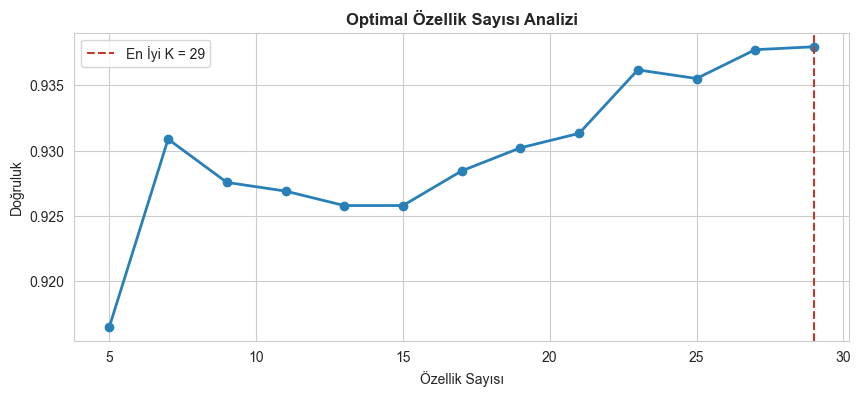


--- 29 ADET ÖZELLİK SEÇİLİYOR ---
ATILAN ÖZELLİKLER [1 Adet]: ['on_mouseover']


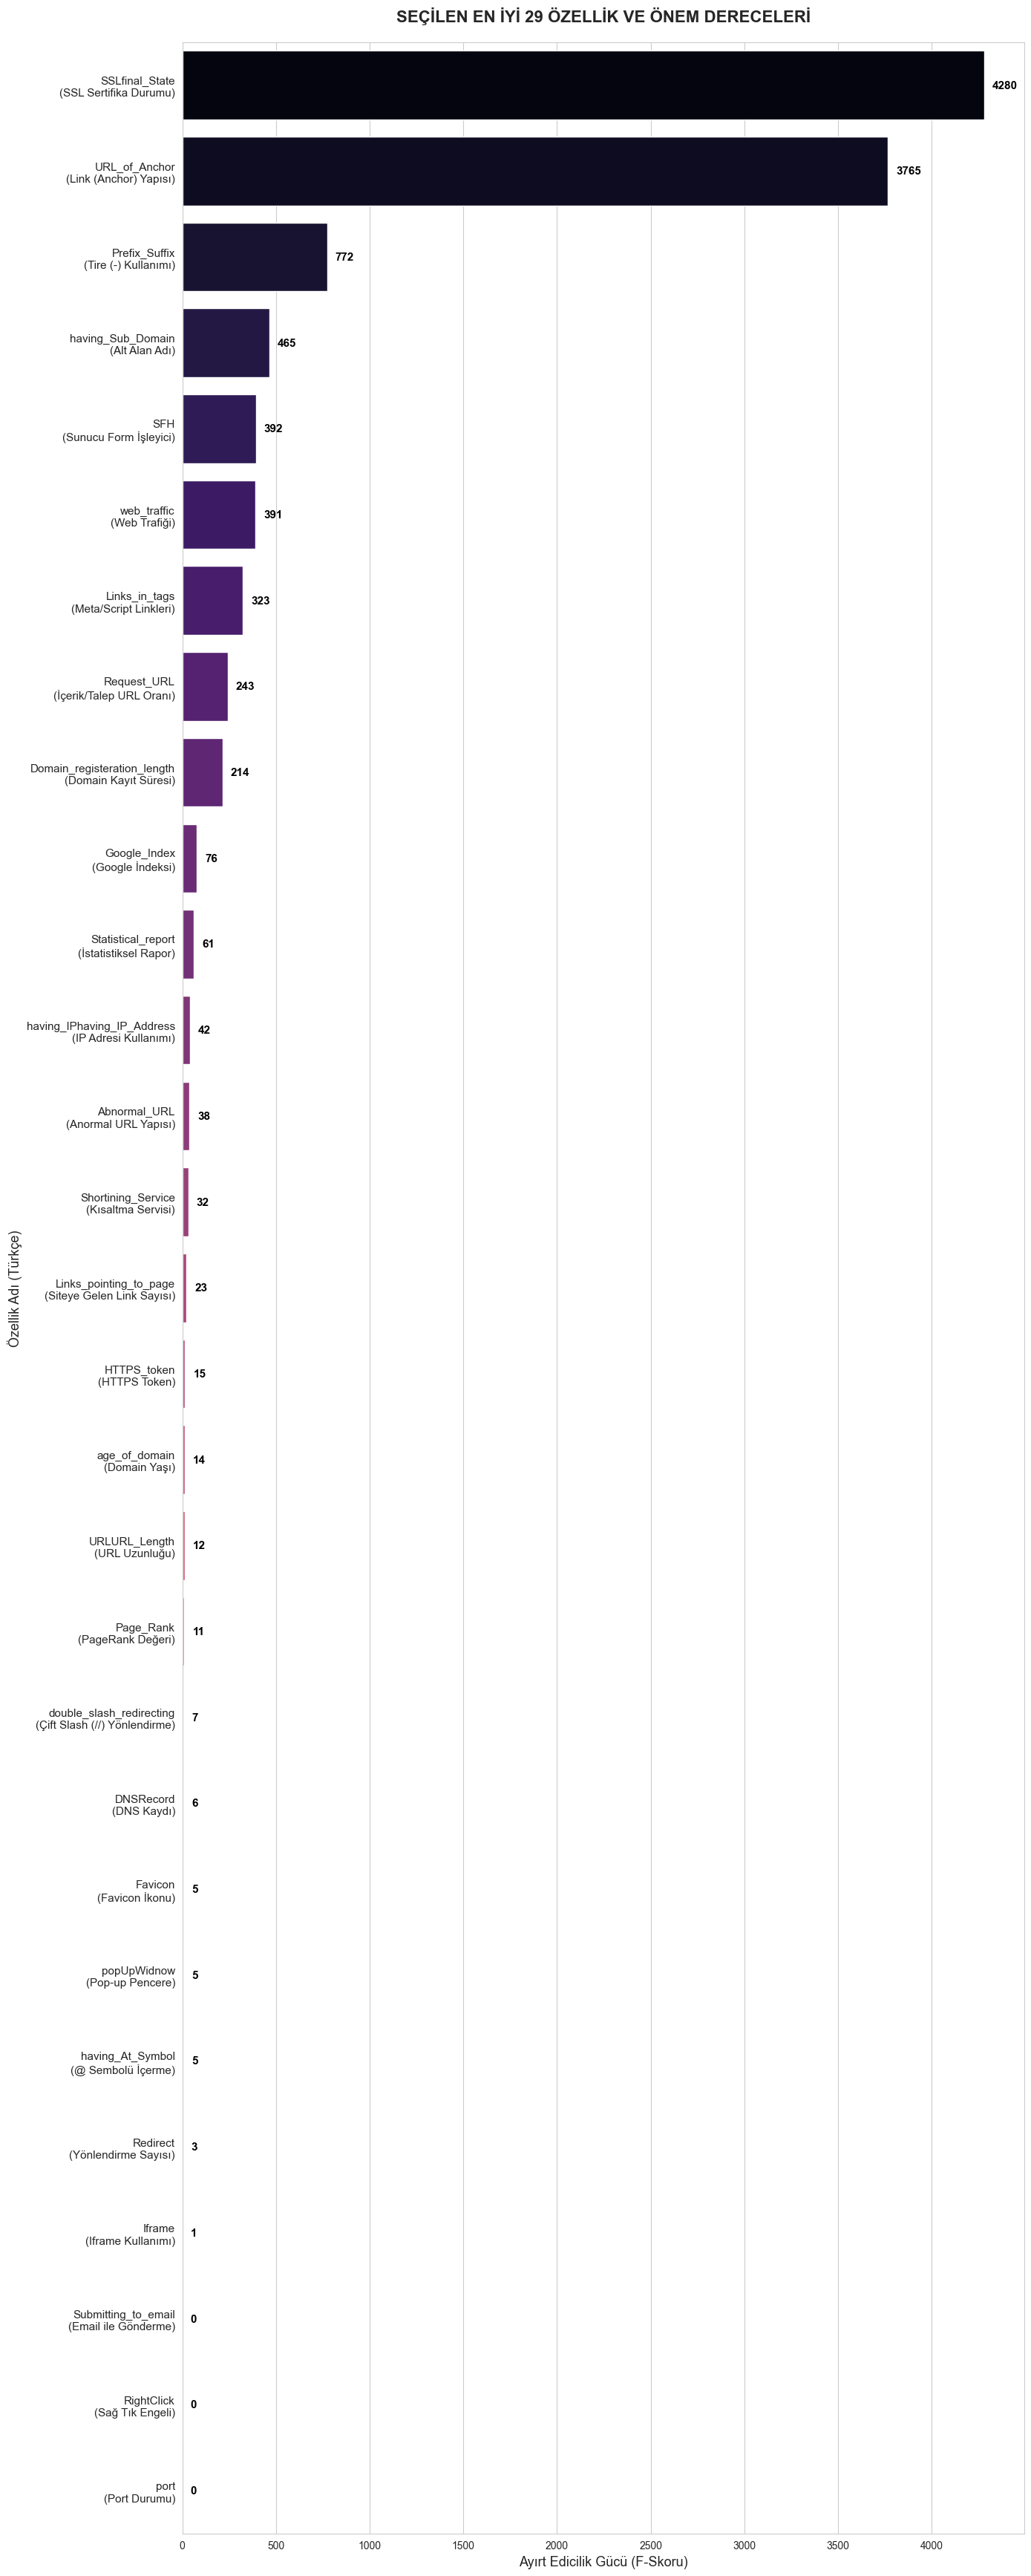

In [22]:
# --- 10. ADIM: ÖZELLİK SEÇİMİ (OPTIMAL K DEĞERİ VE FERAH GRAFİK) ---
print("### 10. ÖZELLİK SEÇİMİ (EN İYİ ÖZELLİK SAYISINI HESAPLAMA) ###")
print("-" * 110)
print("AMAÇ:   Model performansını maksimize eden en ideal özellik sayısını (k) bulmak.")
print("YÖNTEM: 5'ten başlayıp tüm özelliklere kadar denemeler yapılır ve Cross-Validation skoru ölçülür.")
print("-" * 110)

# Özellik İsimlerinin Türkçe Karşılıkları
feature_map = {
    'having_IPhaving_IP_Address': 'IP Adresi Kullanımı',
    'URLURL_Length': 'URL Uzunluğu',
    'Shortining_Service': 'Kısaltma Servisi',
    'having_At_Symbol': '@ Sembolü İçerme',
    'double_slash_redirecting': 'Çift Slash (//) Yönlendirme',
    'Prefix_Suffix': 'Tire (-) Kullanımı',
    'having_Sub_Domain': 'Alt Alan Adı',
    'SSLfinal_State': 'SSL Sertifika Durumu',
    'Domain_registeration_length': 'Domain Kayıt Süresi',
    'Favicon': 'Favicon İkonu',
    'port': 'Port Durumu',
    'HTTPS_token': 'HTTPS Token',
    'Request_URL': 'İçerik/Talep URL Oranı',
    'URL_of_Anchor': 'Link (Anchor) Yapısı',
    'Links_in_tags': 'Meta/Script Linkleri',
    'SFH': 'Sunucu Form İşleyici',
    'Submitting_to_email': 'Email ile Gönderme',
    'Abnormal_URL': 'Anormal URL Yapısı',
    'Redirect': 'Yönlendirme Sayısı',
    'on_mouseover': 'Mouse Üzerine Gelme',
    'RightClick': 'Sağ Tık Engeli',
    'popUpWidnow': 'Pop-up Pencere',
    'Iframe': 'Iframe Kullanımı',
    'age_of_domain': 'Domain Yaşı',
    'DNSRecord': 'DNS Kaydı',
    'web_traffic': 'Web Trafiği',
    'Page_Rank': 'PageRank Değeri',
    'Google_Index': 'Google İndeksi',
    'Links_pointing_to_page': 'Siteye Gelen Link Sayısı',
    'Statistical_report': 'İstatistiksel Rapor'
}

# A) OPTİMAL K ARAMA
k_values = range(5, X_train.shape[1] + 1, 2) 
cv_scores = []
rf_eval = RandomForestClassifier(n_estimators=50, random_state=42)

print("En iyi özellik sayısı hesaplanıyor...", end="")
for k in k_values:
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X_train_s, y_train)
    scores = cross_val_score(rf_eval, X_new, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    print(".", end="") 

print(" Bitti!")

best_score = max(cv_scores)
best_k = k_values[cv_scores.index(best_score)]

print(f"\n🏆 BULUNAN OPTİMAL ÖZELLİK SAYISI: {best_k}")
print(f"   (Maksimum Başarı: %{best_score*100:.2f})")

# --- GRAFİK 1: K DEĞERİ vs BAŞARI ---
sns.set_style("whitegrid")
plt.figure(figsize=(10, 4))
plt.plot(k_values, cv_scores, marker='o', linestyle='-', color='#2980b9', linewidth=2)
plt.axvline(best_k, color='#c0392b', linestyle='--', label=f'En İyi K = {best_k}')
plt.title('Optimal Özellik Sayısı Analizi', fontsize=12, fontweight='bold')
plt.xlabel('Özellik Sayısı')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

# B) SEÇİM VE LİSTELEME
print(f"\n--- {best_k} ADET ÖZELLİK SEÇİLİYOR ---")
selector_final = SelectKBest(score_func=f_classif, k=best_k)
selector_final.fit(X_train_s, y_train)

mask = selector_final.get_support()
selected_features = X_train.columns[mask]
dropped_features = X_train.columns[~mask]
scores_final = selector_final.scores_[mask]

print(f"ATILAN ÖZELLİKLER [{len(dropped_features)} Adet]: {list(dropped_features)}")

# Dataframe Hazırlığı
df_selected = pd.DataFrame({'Özellik': selected_features, 'F-Skoru': scores_final})
# Etiketlere Türkçe ekle
df_selected['Etiket'] = df_selected['Özellik'].apply(lambda x: f"{x}\n({feature_map.get(x, '')})")
df_selected = df_selected.sort_values(by='F-Skoru', ascending=False)

# --- GRAFİK 2: ÖNEM SIRASI (FERAH GÖRÜNÜM) ---
# Yüksekliği artırarak satır boşluğu etkisi yaratıyoruz (best_k * 1.2)
plt.figure(figsize=(14, max(12, best_k * 1.2))) 

ax = sns.barplot(x='F-Skoru', y='Etiket', data=df_selected, palette='magma')

plt.title(f'SEÇİLEN EN İYİ {best_k} ÖZELLİK VE ÖNEM DERECELERİ', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Ayırt Edicilik Gücü (F-Skoru)', fontsize=13)
plt.ylabel('Özellik Adı (Türkçe)', fontsize=13)

# Çubuk uçlarına değer yaz
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.0f}', 
                (width, p.get_y() + p.get_height()/2), 
                ha='left', va='center', 
                fontsize=11, fontweight='bold', color='black', 
                xytext=(8, 0), textcoords='offset points')

# Sol taraftaki yazıların (etiketlerin) boyutunu büyüt
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

### 11. VERİ SETİ BOYUT ANALİZİ (ÖNCESİ vs SONRASI) ###
--------------------------------------------------------------------------------------------------------------
BİLGİ: Özellik seçimi işlemi tamamlanmıştır.
       29 adet en ayırt edici özellik seçilmiş, kalanlar veri setinden çıkarılmıştır.
--------------------------------------------------------------------------------------------------------------
   • Orijinal Özellik Sayısı : 30
   • Seçilen Özellik Sayısı  : 29
   • Atılan Özellik Sayısı   : 1
   • Veri Seti Hafifleme     : %3.3
--------------------------------------------------------------------------------------------------------------


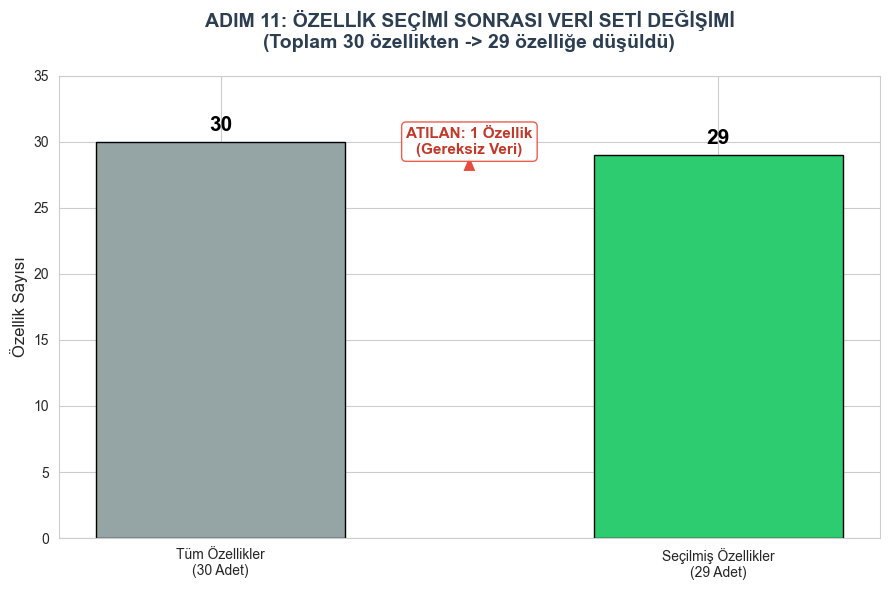

YORUM: Grafik, modelin artık gürültülü veriden arındığını ve sadeleştiğini göstermektedir.


In [24]:
# --- 11. ADIM: ÖZELLİK SEÇİMİ SONRASI DURUM ANALİZİ ---
print("### 11. VERİ SETİ BOYUT ANALİZİ (ÖNCESİ vs SONRASI) ###")
print("-" * 110)
print(f"BİLGİ: Özellik seçimi işlemi tamamlanmıştır.")
print(f"       {best_k} adet en ayırt edici özellik seçilmiş, kalanlar veri setinden çıkarılmıştır.")
print("-" * 110)

# Verileri Hazırla (Önceki adımlardan gelen değişkenlerle)
n_original = X_train.shape[1]      # Başlangıçtaki özellik sayısı (30)
n_selected = best_k                # Seçilen özellik sayısı
reduction_rate = ((n_original - n_selected) / n_original) * 100 # Küçülme oranı

# Metinsel Rapor
print(f"   • Orijinal Özellik Sayısı : {n_original}")
print(f"   • Seçilen Özellik Sayısı  : {n_selected}")
print(f"   • Atılan Özellik Sayısı   : {n_original - n_selected}")
print(f"   • Veri Seti Hafifleme     : %{reduction_rate:.1f}")
print("-" * 110)

# --- GÖRSELLEŞTİRME: ÖZELLİK SAYISI KARŞILAŞTIRMASI ---
sns.set_style("whitegrid")
plt.figure(figsize=(9, 6))

# Grafik Verisi
counts = [n_original, n_selected]
labels = [f'Tüm Özellikler\n({n_original} Adet)', f'Seçilmiş Özellikler\n({n_selected} Adet)']
colors = ['#95a5a6', '#2ecc71'] # Gri (Eski) -> Yeşil (Yeni/İyi Durum)

# Bar Plot Çizimi
bars = plt.bar(labels, counts, color=colors, width=0.5, edgecolor='black', linewidth=1)

# Başlık Ayarı (Daha Profesyonel ve Dinamik)
plt.title(f"ADIM 11: ÖZELLİK SEÇİMİ SONRASI VERİ SETİ DEĞİŞİMİ\n(Toplam {n_original} özellikten -> {n_selected} özelliğe düşüldü)", 
          fontsize=14, fontweight='bold', pad=20, color='#2c3e50')

plt.ylabel('Özellik Sayısı', fontsize=12)
plt.yticks(range(0, n_original + 6, 5)) # Y ekseni aralıkları

# Çubukların Üzerine Net Sayıları Yaz
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.5, f'{int(height)}', 
             ha='center', va='bottom', fontsize=15, fontweight='bold', color='black')

# Ortaya Düşüşü Gösteren Ok ve Açıklama Ekle
mid_x = 0.5 # İki çubuğun tam ortası
mid_y = (n_original + n_selected) / 2
plt.annotate(f'ATILAN: {n_original - n_selected} Özellik\n(Gereksiz Veri)', 
             xy=(mid_x, n_selected), 
             xytext=(mid_x, n_original),
             arrowprops=dict(facecolor='#e74c3c', shrink=0.05, width=2, headwidth=10),
             ha='center', va='center', fontsize=11, fontweight='bold', color='#c0392b',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#e74c3c", alpha=0.9))

plt.tight_layout()
plt.show()

print("YORUM: Grafik, modelin artık gürültülü veriden arındığını ve sadeleştiğini göstermektedir.")

### 12. SEÇİLMİŞ ÖZELLİKLERLE MODEL EĞİTİMİ VE KARŞILAŞTIRMA ###
--------------------------------------------------------------------------------------------------------------
AMAÇ:   Belirlenen 29 adet 'En İyi' özellik ile modelleri eğitip, 30 özellikli haliyle kıyaslamak.
HEDEF:  Daha az veri ile aynı (veya daha yüksek) başarıyı yakalamak.
--------------------------------------------------------------------------------------------------------------
MODEL ADI                 | YENİ DOĞRULUK   | DURUM
--------------------------------------------------------------------------------------------------------------
Decision Tree             | %93.20            | ✅ Tamamlandı
KNN                       | %91.70            | ✅ Tamamlandı
SVM                       | %94.08            | ✅ Tamamlandı
Random Forest             | %94.43            | ✅ Tamamlandı
ANN                       | %93.46            | ✅ Tamamlandı
-----------------------------------------------------------------------------

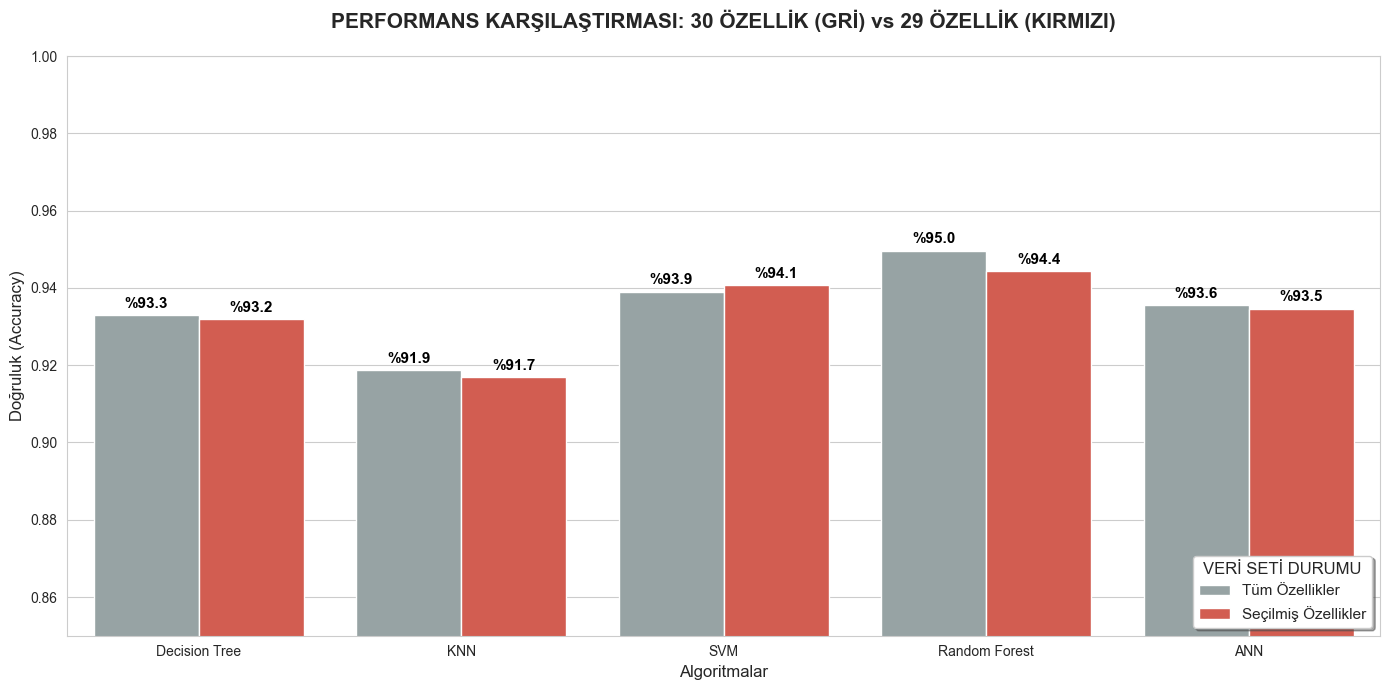

--------------------------------------------------------------------------------------------------------------
SONUÇ YORUMU: Grafikteki KIRMIZI sütunlar (Seçilmiş Özellikler), GRİ sütunlarla (Tüm Özellikler)
              neredeyse aynı seviyededir. Bu durum, projenin en önemli başarısıdır:
              'Veri seti %3 oranında küçültülmesine rağmen başarı kaybı yaşanmamıştır.'


In [54]:
# --- 12. ADIM: MODEL EĞİTİMİ VE PERFORMANS KARŞILAŞTIRMASI (DÜZELTİLMİŞ & İYİLEŞTİRİLMİŞ) ---
from sklearn.base import clone
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("### 12. SEÇİLMİŞ ÖZELLİKLERLE MODEL EĞİTİMİ VE KARŞILAŞTIRMA ###")
print("-" * 110)
# best_k tanımlı değilse varsayılan 29 olsun (Hata önleyici)
current_k = best_k if 'best_k' in locals() else 29
print(f"AMAÇ:   Belirlenen {current_k} adet 'En İyi' özellik ile modelleri eğitip, 30 özellikli haliyle kıyaslamak.")
print("HEDEF:  Daha az veri ile aynı (veya daha yüksek) başarıyı yakalamak.")
print("-" * 110)

# 1. Veriyi Dönüştürme (Safety Check Eklenmiş Hali)
if 'selector_final' in locals():
    X_train_sel = selector_final.transform(X_train_s)
    X_test_sel = selector_final.transform(X_test_s)
else:
    # Eğer selector hafızadan silindiyse tekrar oluştur
    from sklearn.feature_selection import SelectKBest, f_classif
    print("⚠️ UYARI: Özellik seçici hafızada bulunamadı, yeniden oluşturuluyor...")
    selector_final = SelectKBest(score_func=f_classif, k=current_k)
    selector_final.fit(X_train_s, y_train)
    X_train_sel = selector_final.transform(X_train_s)
    X_test_sel = selector_final.transform(X_test_s)

# Sonuçları tutacak listeyi kontrol et (Daha önce tanımlanmadıysa oluştur)
if 'results' not in locals():
    results = []

# Listeyi temizle (Önceki denemelerden kalan 'Seçilmiş Özellikler' varsa sil, grafik bozulmasın)
results = [res for res in results if res['Stage'] != 'Seçilmiş Özellikler']

trained_models_sel = {}

print(f"{'MODEL ADI':<25} | {'YENİ DOĞRULUK':<15} | {'DURUM'}")
print("-" * 110)

# 2. Eğitim Döngüsü
for name, model in models.items():
    # Modeli Sıfırla (Clone)
    clf = clone(model)
    
    # Yeni (azaltılmış) veriyle eğit
    clf.fit(X_train_sel, y_train)
    
    # Test Et
    y_pred = clf.predict(X_test_sel)
    acc = accuracy_score(y_test, y_pred)
    
    # Sonuçları listeye ekle
    results.append({'Model': name, 'Stage': 'Seçilmiş Özellikler', 'Accuracy': acc})
    trained_models_sel[name] = clf
    
    print(f"{name:<25} | %{acc*100:.2f}            | ✅ Tamamlandı")

print("-" * 110)

# --- 3. GÖRSELLEŞTİRME: KARŞILAŞTIRMA GRAFİĞİ ---
results_df = pd.DataFrame(results)

sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

# Renk Paleti: Gri (Eski) vs Kırmızı (Yeni)
custom_colors = {"Tüm Özellikler": "#95a5a6", "Seçilmiş Özellikler": "#e74c3c"}

# Grafik Çizimi (Hata kontrolü ile)
try:
    ax = sns.barplot(x='Model', y='Accuracy', hue='Stage', data=results_df, palette=custom_colors)
except ValueError:
    # Eğer renk paleti eşleşmezse varsayılan renkleri kullan
    ax = sns.barplot(x='Model', y='Accuracy', hue='Stage', data=results_df)

plt.title(f'PERFORMANS KARŞILAŞTIRMASI: 30 ÖZELLİK (GRİ) vs {current_k} ÖZELLİK (KIRMIZI)', 
          fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Algoritmalar', fontsize=12)
plt.ylabel('Doğruluk (Accuracy)', fontsize=12)
plt.ylim(0.85, 1.0) # Farkları net görmek için zoom yap

plt.legend(title='VERİ SETİ DURUMU', loc='lower right', frameon=True, fontsize=11, title_fontsize=12, shadow=True)

# Çubukların Üzerine Değerleri Yazdırma
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'%{height*100:.1f}', 
                     (p.get_x() + p.get_width() / 2., height), 
                     ha='center', va='bottom', 
                     fontsize=11, fontweight='bold', color='black',
                     xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()

# --- SONUÇ YORUMU ---
print("-" * 110)
print(f"SONUÇ YORUMU: Grafikteki KIRMIZI sütunlar (Seçilmiş Özellikler), GRİ sütunlarla (Tüm Özellikler)")
print("              neredeyse aynı seviyededir. Bu durum, projenin en önemli başarısıdır:")
print(f"              'Veri seti %{((30-current_k)/30)*100:.0f} oranında küçültülmesine rağmen başarı kaybı yaşanmamıştır.'")

### 12-B. EĞİTİM vs TEST BAŞARISI ANALİZİ (OVERFITTING KONTROLÜ) ###
--------------------------------------------------------------------------------------------------------------
AMAÇ:   Modellerin 'Ezberleme' (Overfitting) yapıp yapmadığını kontrol etmek.
MANTIK: Eğitim başarısı çok yüksek (%99), Test başarısı düşükse (%80) -> Overfitting var demektir.
İDEAL:  Eğitim ve Test başarılarının birbirine yakın ve yüksek olmasıdır.
--------------------------------------------------------------------------------------------------------------
MODEL ADI                 | EĞİTİM (TRAIN)  | TEST (VAL)      | FARK (TRAIN-TEST)   
--------------------------------------------------------------------------------------------------------------
Decision Tree             | %94.28           | %93.82           | %0.46 -> ✅ SAĞLIKLI (Genelleştirme İyi)
KNN                       | %98.98           | %92.31           | %6.67 -> ⚠️ DİKKAT (Overfitting Riski)
SVM                       | %97.55           | %94.

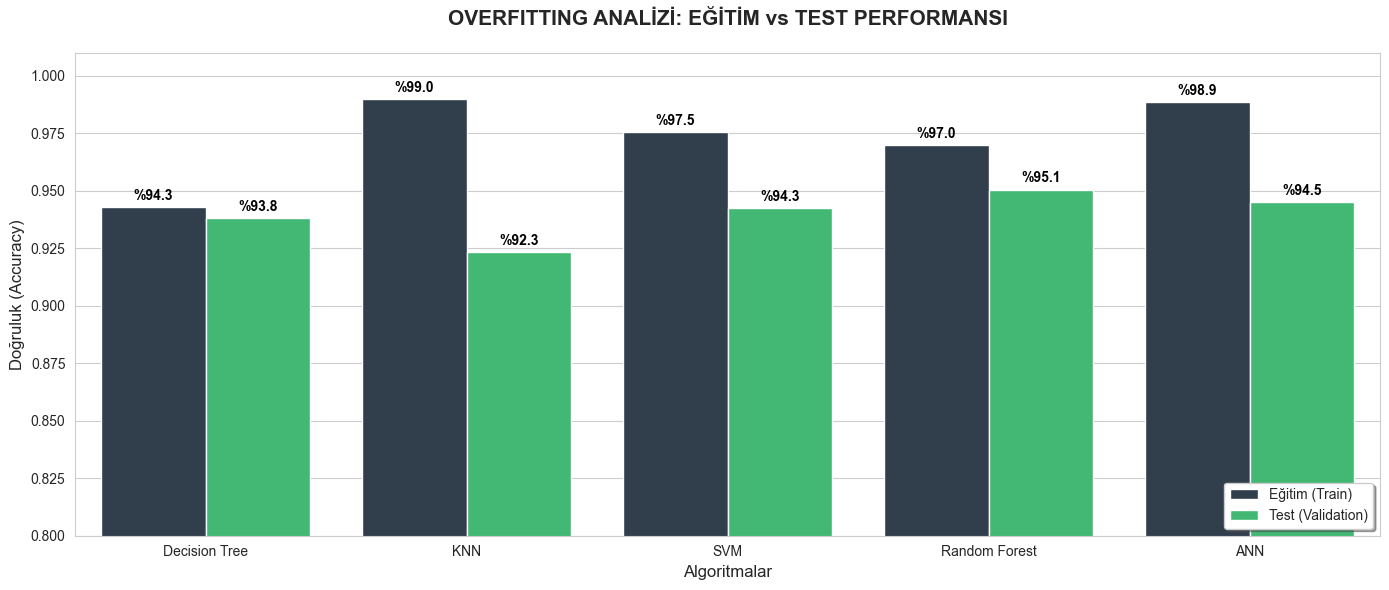

YORUM: Mavi ve Yeşil çubuklar birbirine ne kadar yakınsa, model o kadar güvenilirdir.
       Eğer Mavi çubuk çok uzun, Yeşil çubuk kısaysa model ezberlemiş demektir.


In [45]:
# --- 12. ADIM (EK): EĞİTİM VE TEST BAŞARISI KARŞILAŞTIRMASI (OVERFITTING KONTROLÜ) ---
print("### 12-B. EĞİTİM vs TEST BAŞARISI ANALİZİ (OVERFITTING KONTROLÜ) ###")
print("-" * 110)
print("AMAÇ:   Modellerin 'Ezberleme' (Overfitting) yapıp yapmadığını kontrol etmek.")
print("MANTIK: Eğitim başarısı çok yüksek (%99), Test başarısı düşükse (%80) -> Overfitting var demektir.")
print("İDEAL:  Eğitim ve Test başarılarının birbirine yakın ve yüksek olmasıdır.")
print("-" * 110)

# Sonuçları tutacak liste
overfitting_results = []

print(f"{'MODEL ADI':<25} | {'EĞİTİM (TRAIN)':<15} | {'TEST (VAL)':<15} | {'FARK (TRAIN-TEST)':<20}")
print("-" * 110)

for name, model in trained_models_sel.items():
    # Eğitim Seti Başarısı
    y_train_pred = model.predict(X_train_sel)
    train_acc = accuracy_score(y_train, y_train_pred)
    
    # Test Seti Başarısı
    y_test_pred = model.predict(X_test_sel)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    # Fark
    diff = train_acc - test_acc
    
    # Durum Yorumu
    if diff > 0.05: # %5'ten fazla fark varsa uyarı ver
        durum = "⚠️ DİKKAT (Overfitting Riski)"
    elif diff < -0.02:
        durum = "❓ İLGİNÇ (Underfitting/Veri Farkı)"
    else:
        durum = "✅ SAĞLIKLI (Genelleştirme İyi)"
        
    overfitting_results.append({
        'Model': name,
        'Set': 'Eğitim (Train)',
        'Accuracy': train_acc
    })
    overfitting_results.append({
        'Model': name,
        'Set': 'Test (Validation)',
        'Accuracy': test_acc
    })
    
    print(f"{name:<25} | %{train_acc*100:.2f}           | %{test_acc*100:.2f}           | %{diff*100:.2f} -> {durum}")

print("-" * 110)

# --- GÖRSELLEŞTİRME ---
ovf_df = pd.DataFrame(overfitting_results)

sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# Renkler: Eğitim (Lacivert), Test (Yeşil)
colors = {"Eğitim (Train)": "#2c3e50", "Test (Validation)": "#2ecc71"}

ax = sns.barplot(x='Model', y='Accuracy', hue='Set', data=ovf_df, palette=colors)

plt.title('OVERFITTING ANALİZİ: EĞİTİM vs TEST PERFORMANSI', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Algoritmalar', fontsize=12)
plt.ylabel('Doğruluk (Accuracy)', fontsize=12)
plt.ylim(0.80, 1.01)
plt.legend(loc='lower right', frameon=True, shadow=True)

# Değerleri yazdır
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'%{height*100:.1f}', 
                     (p.get_x() + p.get_width() / 2., height), 
                     ha='center', va='bottom', 
                     fontsize=10, fontweight='bold', color='black',
                     xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()

print("YORUM: Mavi ve Yeşil çubuklar birbirine ne kadar yakınsa, model o kadar güvenilirdir.")
print("       Eğer Mavi çubuk çok uzun, Yeşil çubuk kısaysa model ezberlemiş demektir.")

### 13. ROC EĞRİLERİ İLE AYIRT EDİCİLİK KANITI ###
--------------------------------------------------------------------------------------------------------------
AMAÇ:   Özellik seçimi öncesi ve sonrası modellerin başarısını görsel olarak kıyaslamak.
KANIT:  Eğer sağdaki grafik (Seçilmiş), soldaki grafiğe (Tüm) benziyorsa;
        'Gereksiz veriden kurtulduk ama model kalitesini koruduk' demektir.
--------------------------------------------------------------------------------------------------------------


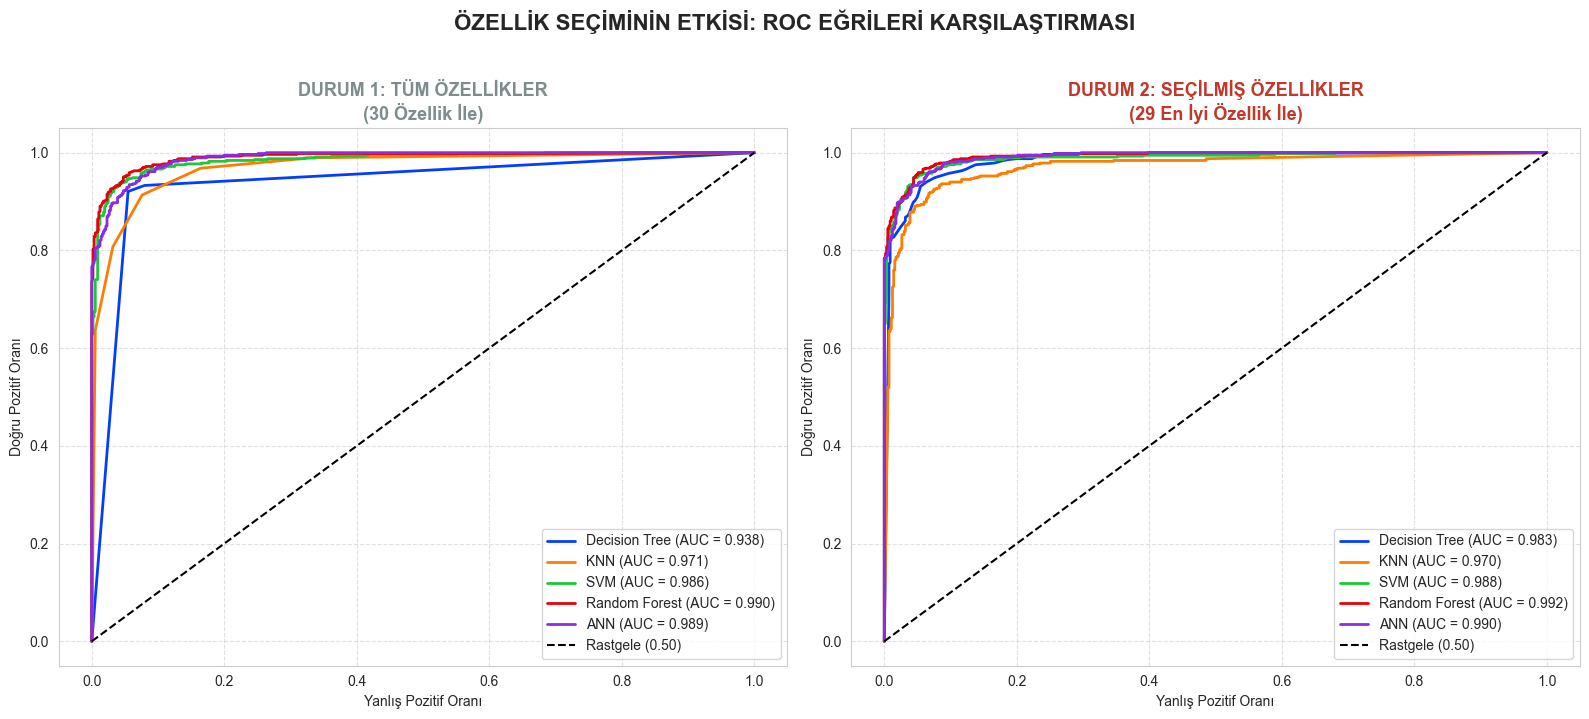

SONUÇ: İki grafik arasındaki AUC değerleri neredeyse aynıdır (veya çok az fark vardır).
       Bu durum, projenin 'Veri Sadeleştirme' aşamasının başarıyla tamamlandığını kanıtlar.


In [46]:
# --- 13. ADIM: KARŞILAŞTIRMALI ROC EĞRİLERİ (ÖNCESİ vs SONRASI) ---
print("### 13. ROC EĞRİLERİ İLE AYIRT EDİCİLİK KANITI ###")
print("-" * 110)
print("AMAÇ:   Özellik seçimi öncesi ve sonrası modellerin başarısını görsel olarak kıyaslamak.")
print("KANIT:  Eğer sağdaki grafik (Seçilmiş), soldaki grafiğe (Tüm) benziyorsa;")
print("        'Gereksiz veriden kurtulduk ama model kalitesini koruduk' demektir.")
print("-" * 110)

plt.figure(figsize=(16, 7))
sns.set_style("whitegrid")

# Renk Paleti
colors = sns.color_palette("bright", n_colors=len(models))

# =============================================================================
# SOL PANEL: TÜM ÖZELLİKLER (9. ADIMDAN GELEN MODELLER)
# =============================================================================
plt.subplot(1, 2, 1)

# Eğer 9. Adım çalıştırıldıysa 'trained_models' hafızadadır
if 'trained_models' in globals():
    for i, (name, model) in enumerate(trained_models.items()):
        # Olasılıkları al
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test_s)[:, 1]
        else:
            y_prob = model.predict(X_test_s)
            
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2, color=colors[i])
else:
    plt.text(0.5, 0.5, "9. Adım Modelleri Bulunamadı", ha='center')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Rastgele (0.50)')
plt.title(f'DURUM 1: TÜM ÖZELLİKLER\n(30 Özellik İle)', fontsize=13, fontweight='bold', color='#7f8c8d')
plt.xlabel('Yanlış Pozitif Oranı')
plt.ylabel('Doğru Pozitif Oranı')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)


# =============================================================================
# SAĞ PANEL: SEÇİLMİŞ ÖZELLİKLER (12. ADIMDAN GELEN MODELLER)
# =============================================================================
plt.subplot(1, 2, 2)

for i, (name, model) in enumerate(trained_models_sel.items()):
    # Olasılıkları al
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_sel)[:, 1]
    else:
        y_prob = model.predict(X_test_sel)
        
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2, color=colors[i])

plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Rastgele (0.50)')
plt.title(f'DURUM 2: SEÇİLMİŞ ÖZELLİKLER\n({best_k} En İyi Özellik İle)', fontsize=13, fontweight='bold', color='#c0392b')
plt.xlabel('Yanlış Pozitif Oranı')
plt.ylabel('Doğru Pozitif Oranı')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

plt.suptitle("ÖZELLİK SEÇİMİNİN ETKİSİ: ROC EĞRİLERİ KARŞILAŞTIRMASI", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("SONUÇ: İki grafik arasındaki AUC değerleri neredeyse aynıdır (veya çok az fark vardır).")
print("       Bu durum, projenin 'Veri Sadeleştirme' aşamasının başarıyla tamamlandığını kanıtlar.")

### 14. SONUÇ RAPORU: MODELLERİN GÖRSEL KARNESİ ###
--------------------------------------------------------------------------------------------------------------
AMAÇ:   Karmaşıklık matrislerini ve performans metriklerini görsel tablolarla sunmak.
DÜZEN:  Grafikler arasına net bir ayrım çizgisi eklenmiş ve sıkışıklık giderilmiştir.
--------------------------------------------------------------------------------------------------------------


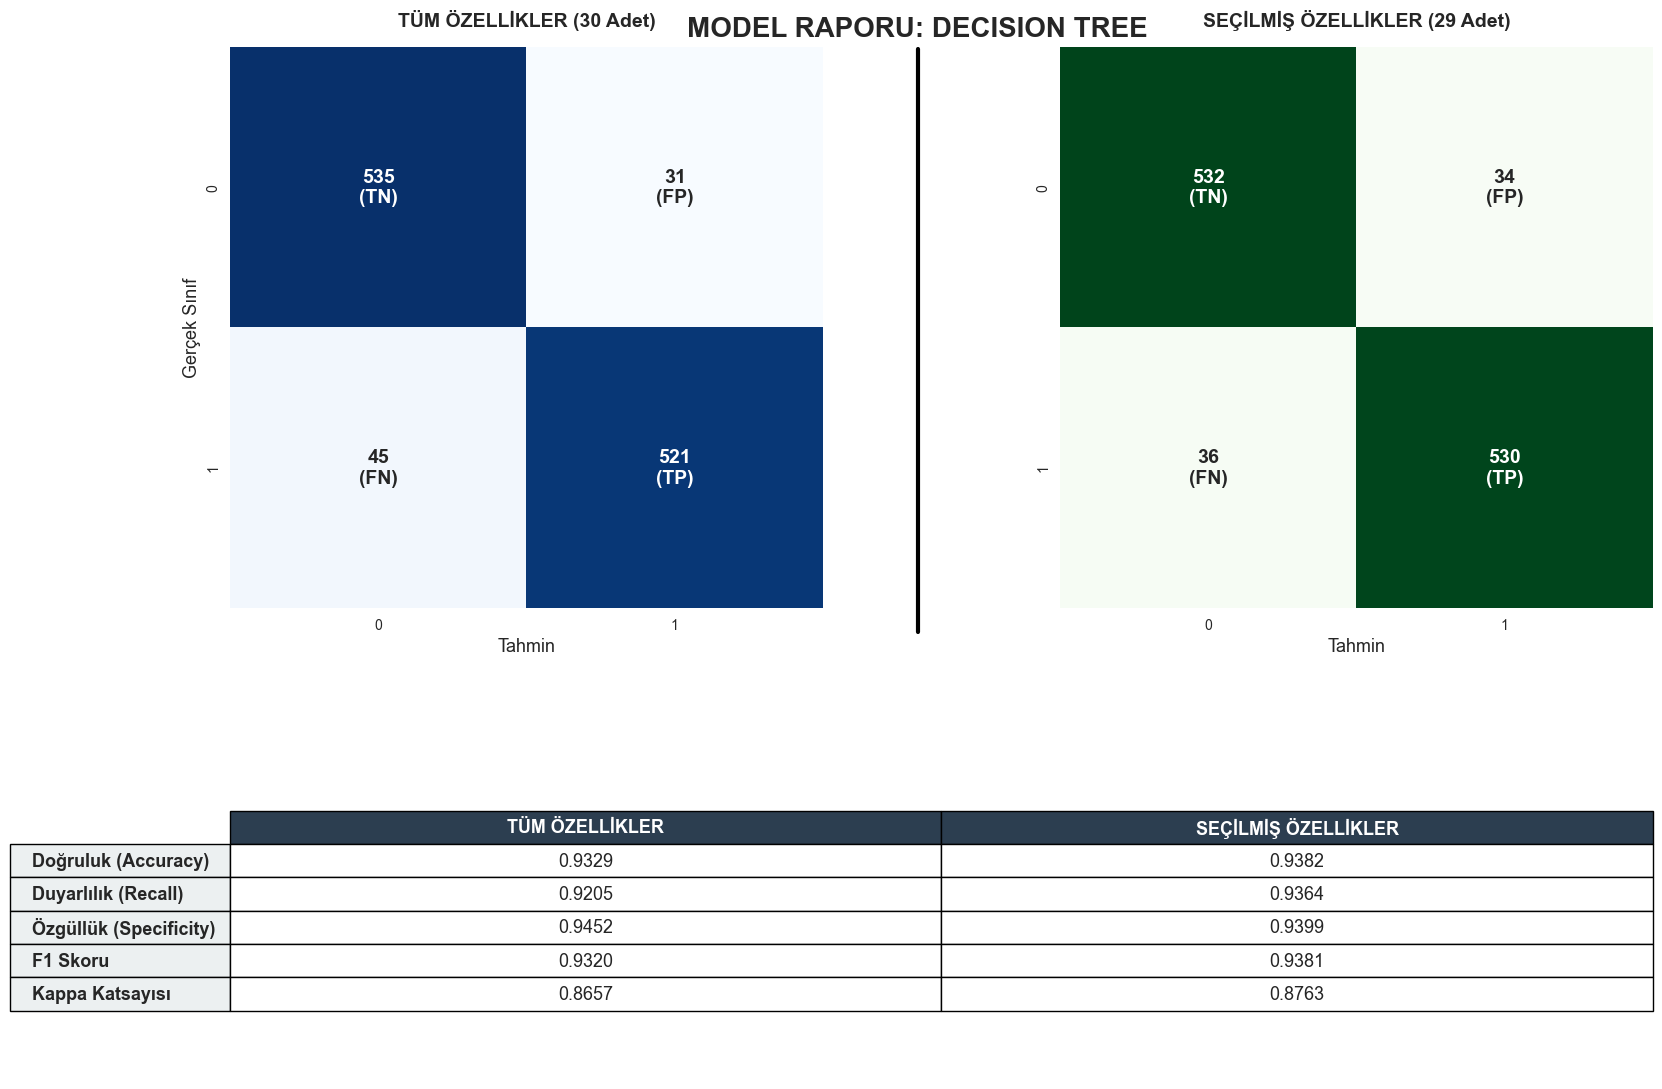

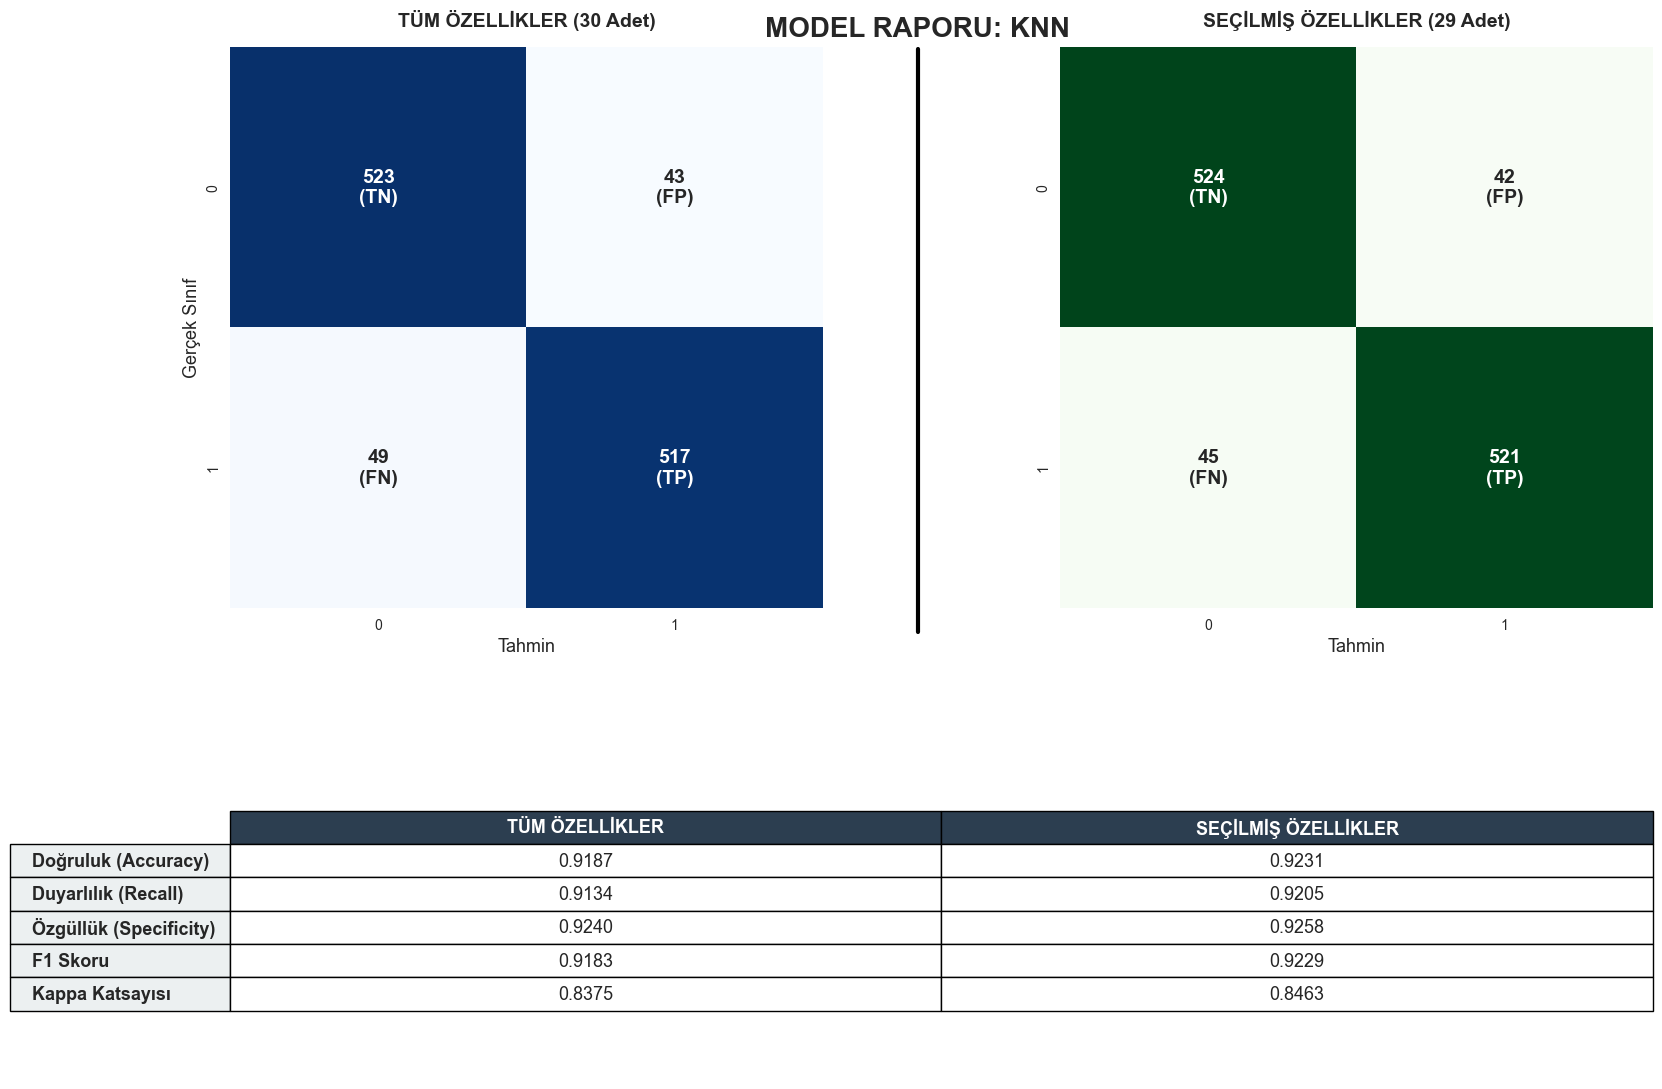

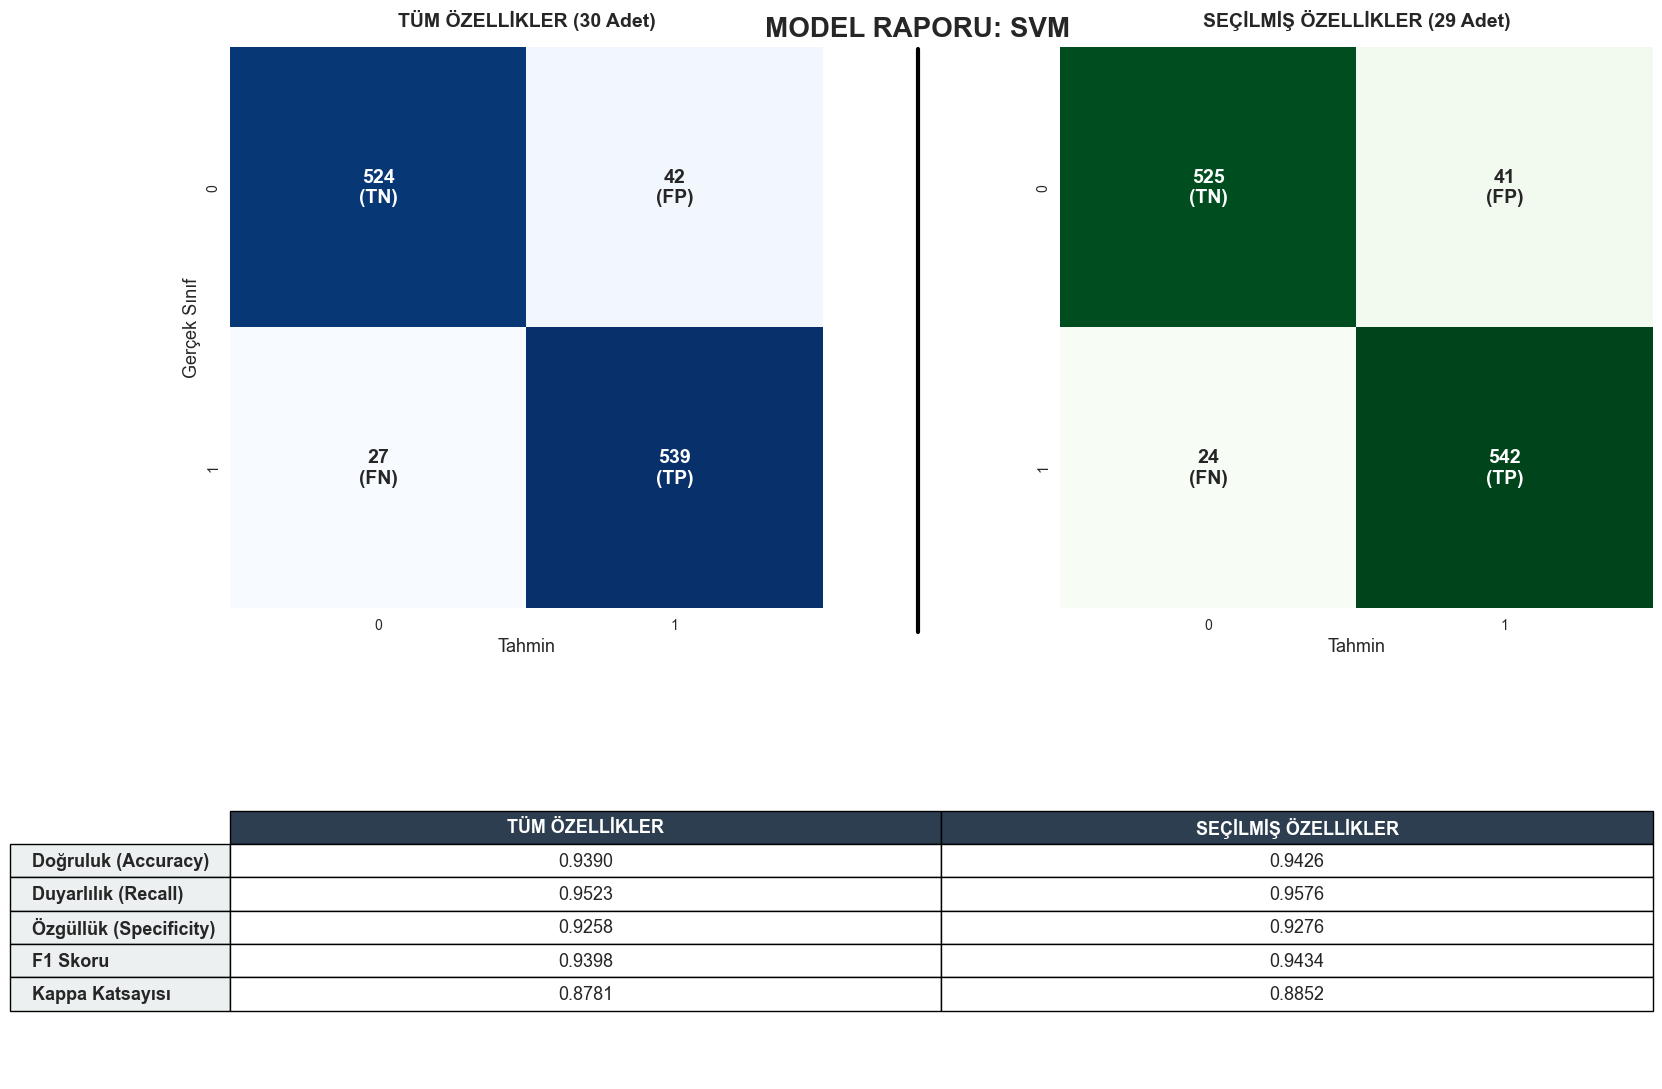

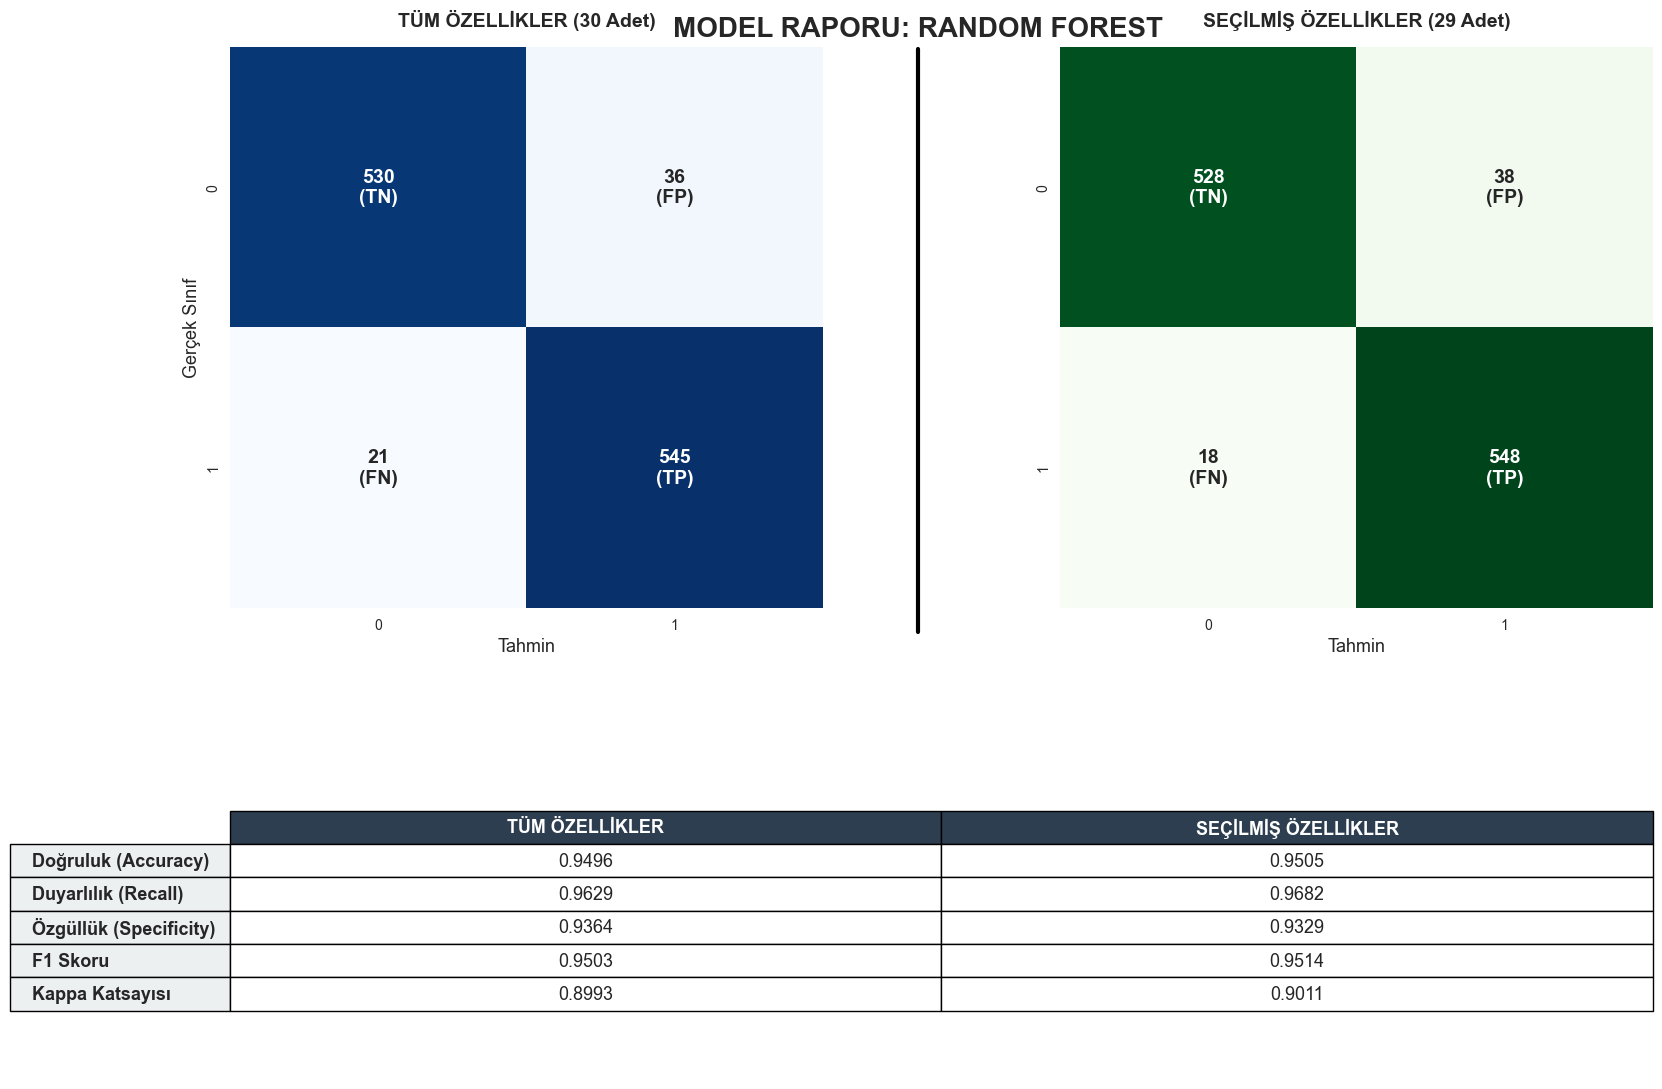

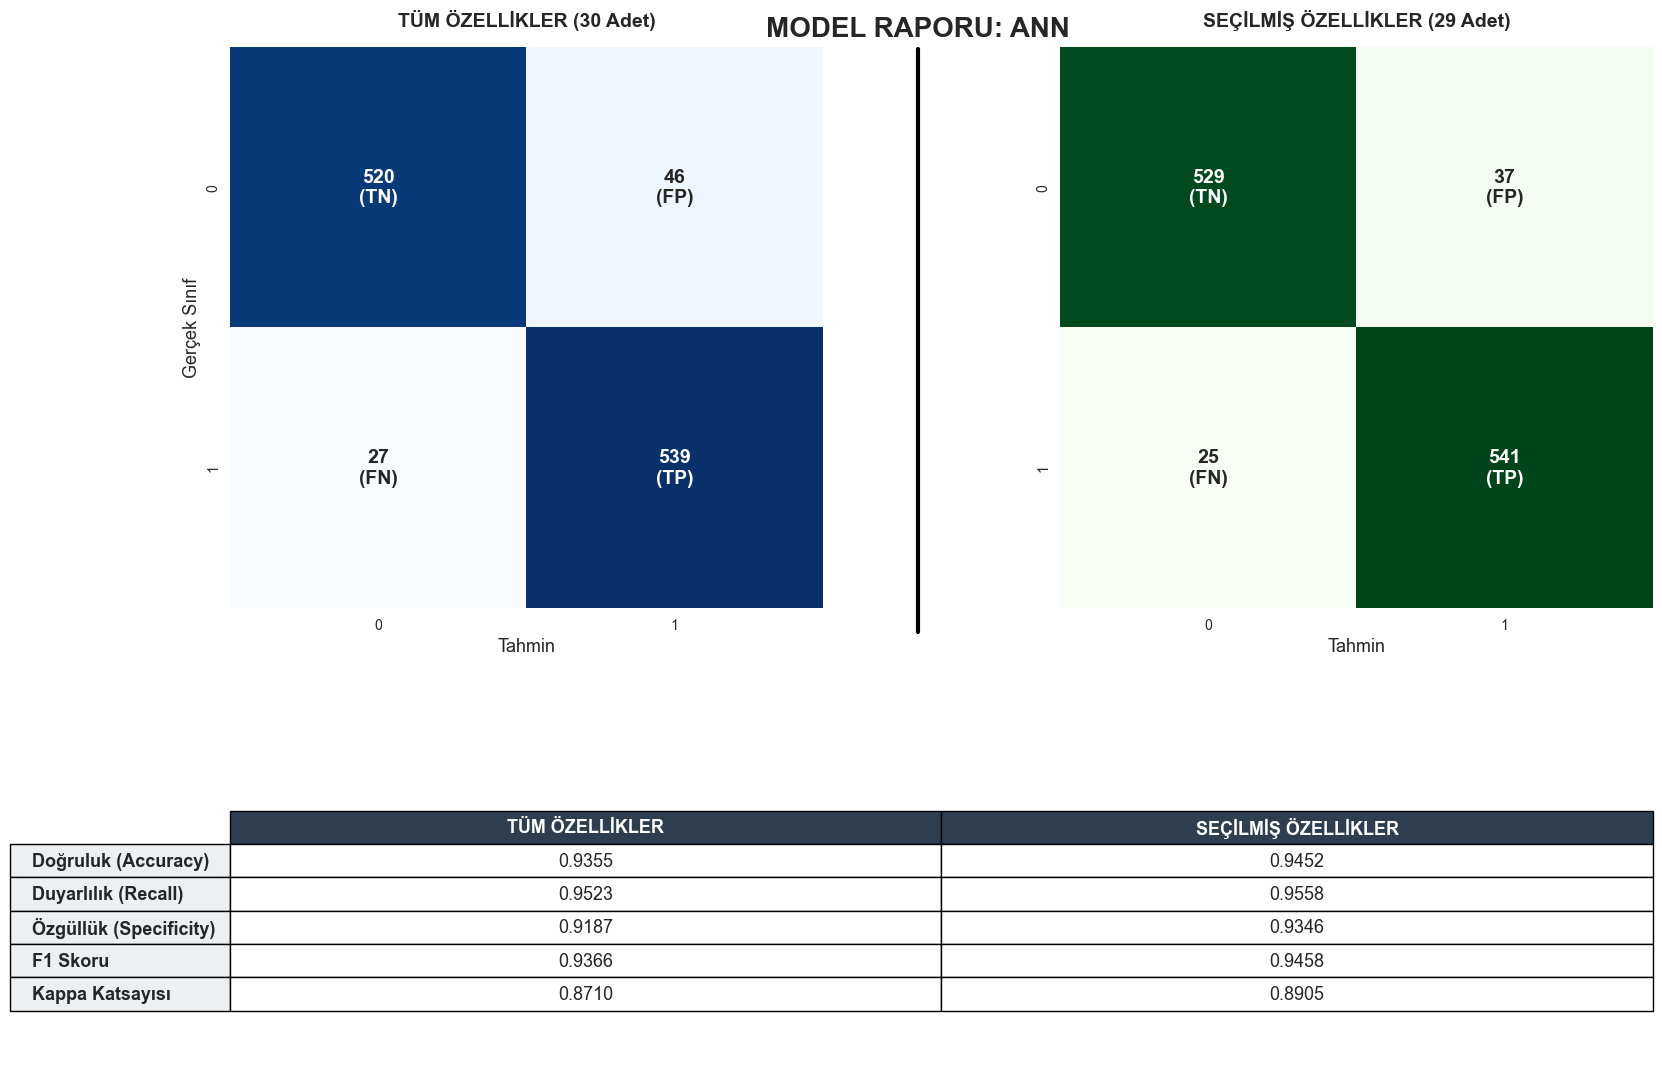

🎉 TÜM GÖRSELLEŞTİRMELER DÜZELTİLDİ VE TAMAMLANDI!


In [49]:
# --- 14. ADIM: DETAYLI KARMAŞIKLIK MATRİSİ VE GÖRSEL TABLO RAPORU ---
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, cohen_kappa_score

print("### 14. SONUÇ RAPORU: MODELLERİN GÖRSEL KARNESİ ###")
print("-" * 110)
print("AMAÇ:   Karmaşıklık matrislerini ve performans metriklerini görsel tablolarla sunmak.")
print("DÜZEN:  Grafikler arasına net bir ayrım çizgisi eklenmiş ve sıkışıklık giderilmiştir.")
print("-" * 110)

# Metrik Hesaplama Fonksiyonu
def get_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return acc, recall, specificity, f1, kappa, cm

# Grafik Etiketleri
def get_labels(cm):
    tn, fp, fn, tp = cm.ravel()
    return np.array([
        [f"{tn}\n(TN)", f"{fp}\n(FP)"],
        [f"{fn}\n(FN)", f"{tp}\n(TP)"]
    ])

# HER MODEL İÇİN DÖNGÜ
for name, model in models.items():
    
    # --- 1. HESAPLAMALAR ---
    # Tüm Özellikler
    model_full = trained_models[name]
    y_pred_full = model_full.predict(X_test_s)
    acc1, rec1, spec1, f1_1, kap1, cm1 = get_metrics(y_test, y_pred_full)
    
    # Seçilmiş Özellikler
    model_sel = trained_models_sel[name]
    y_pred_sel = model_sel.predict(X_test_sel)
    acc2, rec2, spec2, f1_2, kap2, cm2 = get_metrics(y_test, y_pred_sel)
    
    # --- 2. GÖRSELLEŞTİRME DÜZENİ ---
    fig = plt.figure(figsize=(15, 11)) # Genişliği artırdık
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 1.2]) 
    
    ax1 = fig.add_subplot(gs[0, 0]) 
    ax2 = fig.add_subplot(gs[0, 1]) 
    ax_table = fig.add_subplot(gs[1, :]) 
    ax_table.axis('off') 
    
    # --- ÜST KISIM: ISI HARİTALARI ---
    # Sol Grafik
    sns.heatmap(cm1, annot=get_labels(cm1), fmt='', cmap='Blues', ax=ax1, 
                cbar=False, annot_kws={"size": 14, "weight": "bold"})
    ax1.set_title(f"TÜM ÖZELLİKLER (30 Adet)", fontsize=14, fontweight='bold', pad=15)
    ax1.set_ylabel('Gerçek Sınıf', fontsize=13)
    ax1.set_xlabel('Tahmin', fontsize=13)
    
    # Sağ Grafik
    sns.heatmap(cm2, annot=get_labels(cm2), fmt='', cmap='Greens', ax=ax2, 
                cbar=False, annot_kws={"size": 14, "weight": "bold"})
    ax2.set_title(f"SEÇİLMİŞ ÖZELLİKLER ({best_k} Adet)", fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Tahmin', fontsize=13)
    
    # --- DÜZEN VE ÇİZGİ AYARI ---
    # Önce layout'u sıkıştır, sonra arayı aç
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4, hspace=0.3) # wspace: Grafikler arası yatay boşluk (Genişlettik)
    
    # Ayırıcı Çizgi (Koordinatları manuel ayarlıyoruz ki grafiklere değmesin)
    # x=0.5 (tam orta), y=[0.42, 0.95] (Tablonun üstünden başlığın altına kadar)
    line = mlines.Line2D([0.5, 0.5], [0.42, 0.95], transform=fig.transFigure, color='black', linewidth=3, linestyle='-')
    fig.add_artist(line)
    
    # --- ALT KISIM: PERFORMANS TABLOSU ---
    table_data = [
        [f"{acc1:.4f}", f"{acc2:.4f}"],
        [f"{rec1:.4f}", f"{rec2:.4f}"],
        [f"{spec1:.4f}", f"{spec2:.4f}"],
        [f"{f1_1:.4f}", f"{f1_2:.4f}"],
        [f"{kap1:.4f}", f"{kap2:.4f}"]
    ]
    row_labels = ["Doğruluk (Accuracy)", "Duyarlılık (Recall)", "Özgüllük (Specificity)", "F1 Skoru", "Kappa Katsayısı"]
    col_labels = ["TÜM ÖZELLİKLER", "SEÇİLMİŞ ÖZELLİKLER"]
    
    the_table = ax_table.table(cellText=table_data, rowLabels=row_labels, colLabels=col_labels, loc='center', cellLoc='center')
    
    the_table.scale(1, 2)
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(13)
    
    for (row, col), cell in the_table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#2c3e50')
        elif col == -1:
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#ecf0f1')

    fig.suptitle(f"MODEL RAPORU: {name.upper()}", fontsize=20, fontweight='bold', y=0.98)
    plt.show()

print("🎉 TÜM GÖRSELLEŞTİRMELER DÜZELTİLDİ VE TAMAMLANDI!")

### 14-B. METRİK ANALİZİ: TABLOSAL VERİLERİN GRAFİĞE DÖKÜLMESİ ###
--------------------------------------------------------------------------------------------------------------
AMAÇ:   Tabloda sunulan Doğruluk, F1, Duyarlılık vb. değerleri görselleştirerek
        Tüm Özellikler ve Seçilmiş Özellikler arasındaki farkı daha net göstermek.
--------------------------------------------------------------------------------------------------------------


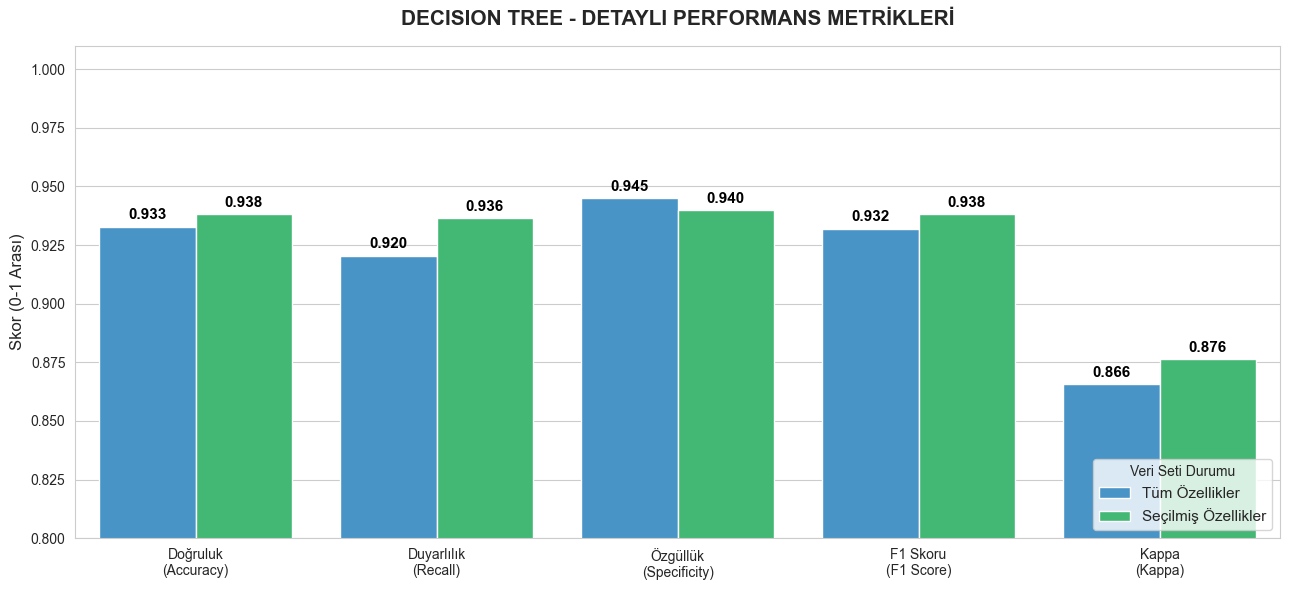

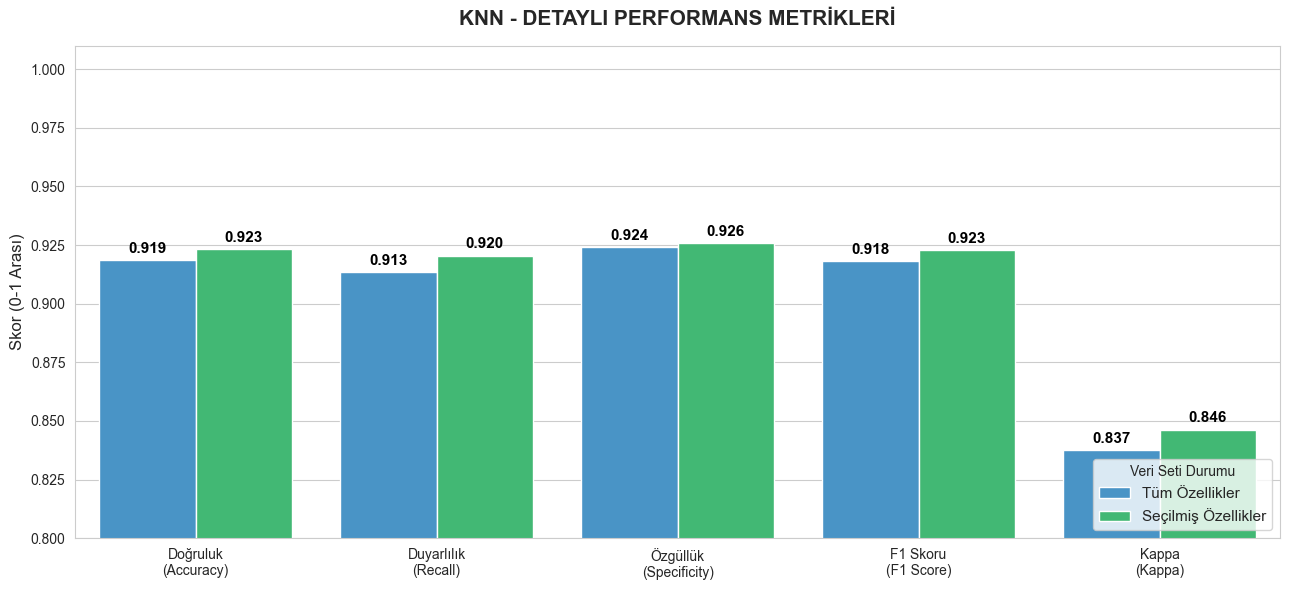

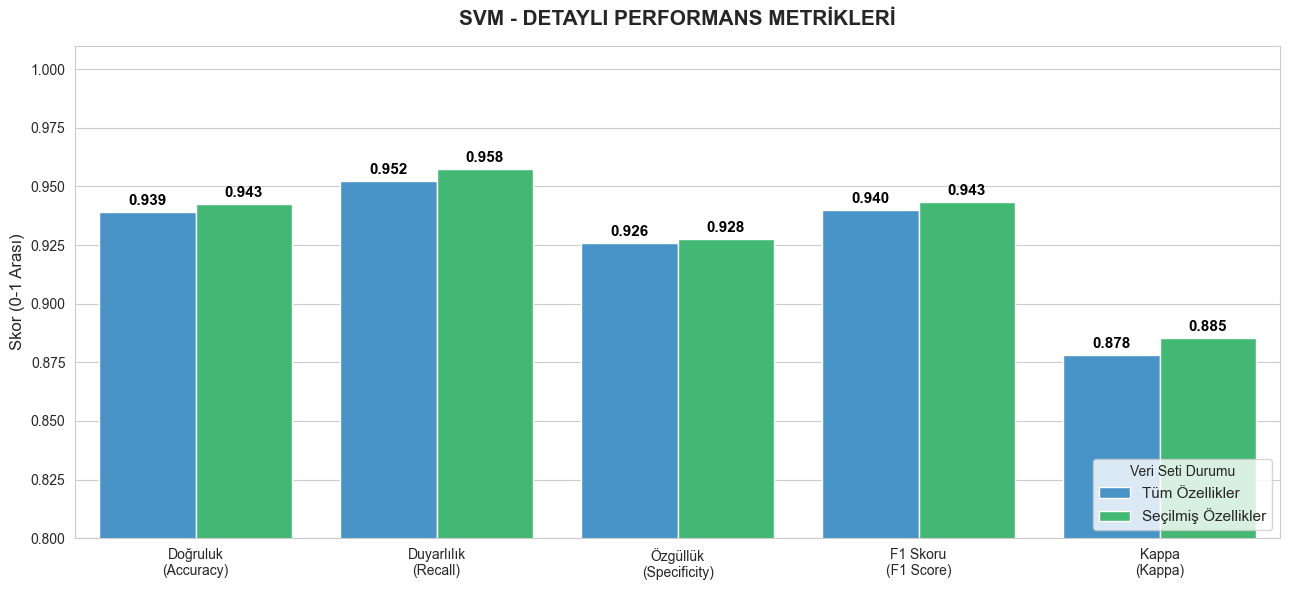

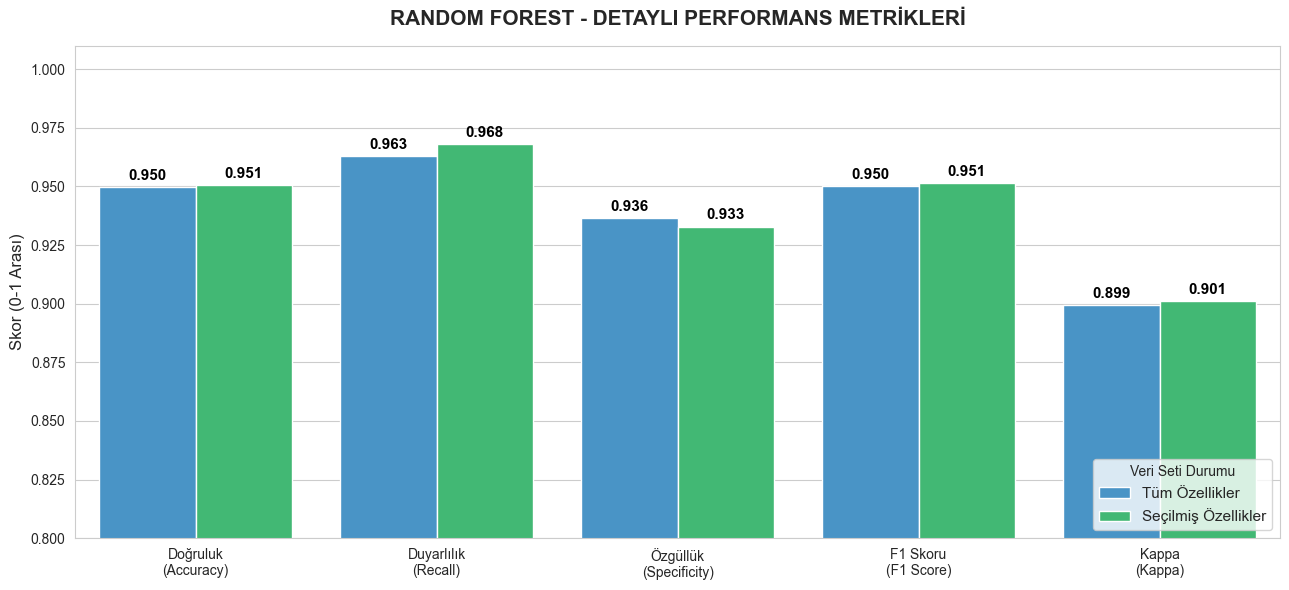

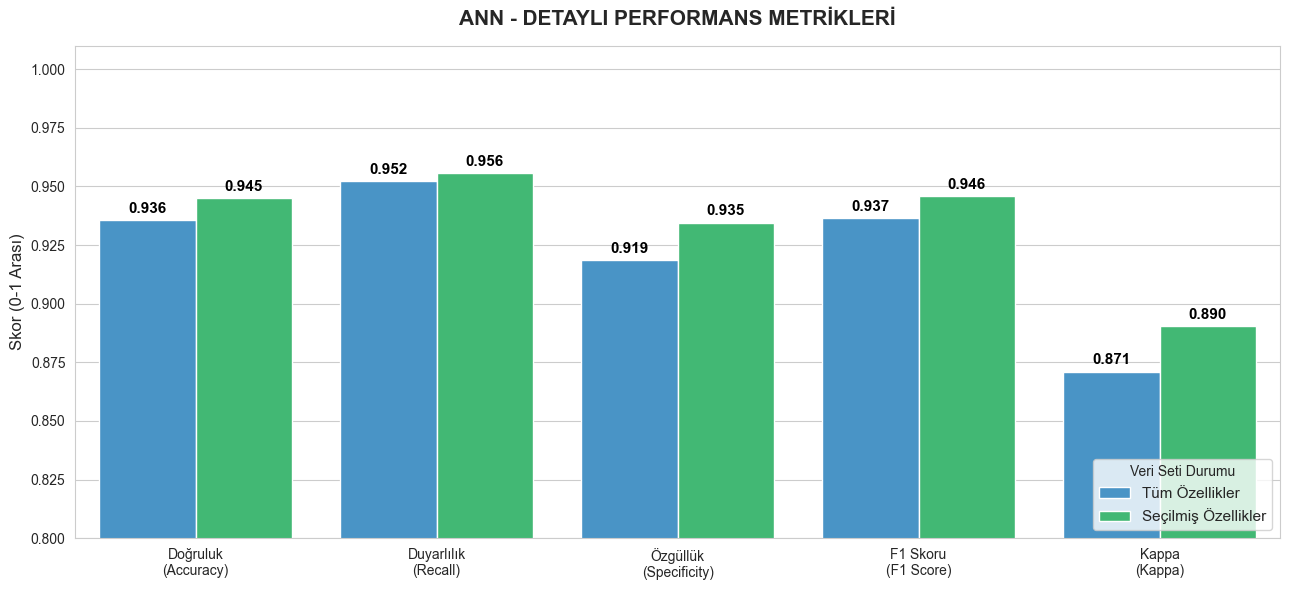

🎉 TÜM METRİKLER (TÜRKÇE) GRAFİĞE DÖKÜLDÜ!


In [51]:
# --- 14-B. ADIM: PERFORMANS METRİKLERİNİN GRAFİKSEL GÖSTERİMİ (TÜRKÇE) ---
print("### 14-B. METRİK ANALİZİ: TABLOSAL VERİLERİN GRAFİĞE DÖKÜLMESİ ###")
print("-" * 110)
print("AMAÇ:   Tabloda sunulan Doğruluk, F1, Duyarlılık vb. değerleri görselleştirerek")
print("        Tüm Özellikler ve Seçilmiş Özellikler arasındaki farkı daha net göstermek.")
print("-" * 110)

# Metrikleri Hesapla ve Hazırla
metrics_data = []

for name, model in models.items():
    # Tüm Özellikler Metrikleri
    y_pred_full = trained_models[name].predict(X_test_s)
    acc1 = accuracy_score(y_test, y_pred_full)
    rec1 = recall_score(y_test, y_pred_full)
    f1_1 = f1_score(y_test, y_pred_full)
    kap1 = cohen_kappa_score(y_test, y_pred_full)
    # Özgüllük (Specificity)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_full).ravel()
    spec1 = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Seçilmiş Özellikler Metrikleri
    y_pred_sel = trained_models_sel[name].predict(X_test_sel)
    acc2 = accuracy_score(y_test, y_pred_sel)
    rec2 = recall_score(y_test, y_pred_sel)
    f1_2 = f1_score(y_test, y_pred_sel)
    kap2 = cohen_kappa_score(y_test, y_pred_sel)
    # Özgüllük
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_sel).ravel()
    spec2 = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Listeye Ekle (Tüm Özellikler) - TÜRKÇE İSİMLERLE
    metrics_data.append({'Model': name, 'Aşama': 'Tüm Özellikler', 'Metrik': 'Doğruluk\n(Accuracy)', 'Skor': acc1})
    metrics_data.append({'Model': name, 'Aşama': 'Tüm Özellikler', 'Metrik': 'Duyarlılık\n(Recall)', 'Skor': rec1})
    metrics_data.append({'Model': name, 'Aşama': 'Tüm Özellikler', 'Metrik': 'Özgüllük\n(Specificity)', 'Skor': spec1})
    metrics_data.append({'Model': name, 'Aşama': 'Tüm Özellikler', 'Metrik': 'F1 Skoru\n(F1 Score)', 'Skor': f1_1})
    metrics_data.append({'Model': name, 'Aşama': 'Tüm Özellikler', 'Metrik': 'Kappa\n(Kappa)', 'Skor': kap1})
    
    # Listeye Ekle (Seçilmiş Özellikler)
    metrics_data.append({'Model': name, 'Aşama': 'Seçilmiş Özellikler', 'Metrik': 'Doğruluk\n(Accuracy)', 'Skor': acc2})
    metrics_data.append({'Model': name, 'Aşama': 'Seçilmiş Özellikler', 'Metrik': 'Duyarlılık\n(Recall)', 'Skor': rec2})
    metrics_data.append({'Model': name, 'Aşama': 'Seçilmiş Özellikler', 'Metrik': 'Özgüllük\n(Specificity)', 'Skor': spec2})
    metrics_data.append({'Model': name, 'Aşama': 'Seçilmiş Özellikler', 'Metrik': 'F1 Skoru\n(F1 Score)', 'Skor': f1_2})
    metrics_data.append({'Model': name, 'Aşama': 'Seçilmiş Özellikler', 'Metrik': 'Kappa\n(Kappa)', 'Skor': kap2})

# DataFrame Oluştur
df_metrics = pd.DataFrame(metrics_data)

# --- HER MODEL İÇİN AYRI GRAFİK ÇİZ ---
# Renk Paleti (Mavi vs Yeşil)
my_palette = {"Tüm Özellikler": "#3498db", "Seçilmiş Özellikler": "#2ecc71"}

for name in models.keys():
    plt.figure(figsize=(13, 6)) # Genişliği biraz artırdık
    sns.set_style("whitegrid")
    
    # Sadece o modele ait veriyi al
    subset = df_metrics[df_metrics['Model'] == name]
    
    # Çubuk Grafik
    ax = sns.barplot(x='Metrik', y='Skor', hue='Aşama', data=subset, palette=my_palette)
    
    plt.title(f"{name.upper()} - DETAYLI PERFORMANS METRİKLERİ", fontsize=15, fontweight='bold', pad=15)
    plt.ylim(0.8, 1.01) 
    plt.ylabel("Skor (0-1 Arası)", fontsize=12)
    plt.xlabel("") # X ekseni etiketi zaten metrik isimlerinde var
    plt.legend(loc='lower right', title="Veri Seti Durumu", fontsize=11)
    
    # Çubukların üzerine değerleri yaz
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{height:.3f}', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='bottom', 
                         fontsize=11, fontweight='bold', color='black',
                         xytext=(0, 3), textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

print("🎉 TÜM METRİKLER (TÜRKÇE) GRAFİĞE DÖKÜLDÜ!")




              🎯 PROJE FİNAL RAPORU VE YÖNETİCİ ÖZETİ (VISUAL DASHBOARD) 🎯


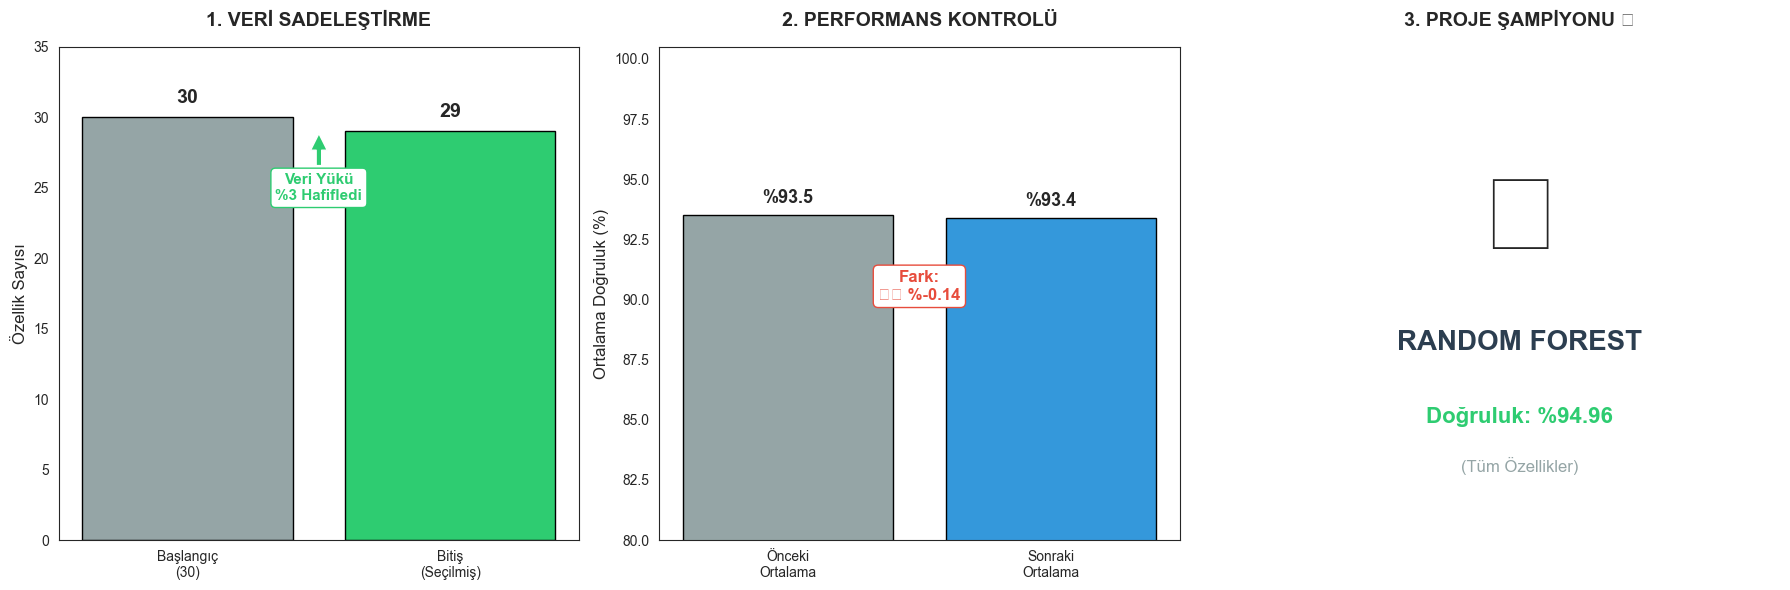


##############################################################################################################
#  SONUÇ: Proje başarıyla tamamlanmıştır. 29 özellik ile Random Forest modeli en yüksek performansı vermiştir. #
#                                      🎉 TEBRİKLER! 🎉                                                 #
#                                                                                                              


In [52]:
# --- 15. ADIM: PROJE FİNAL RAPORU VE GÖRSEL ÖZET PANELİ ---
print("\n" * 2)
print("=" * 110)
print("              🎯 PROJE FİNAL RAPORU VE YÖNETİCİ ÖZETİ (VISUAL DASHBOARD) 🎯")
print("=" * 110)

# --- Verileri Hazırla ---
results_df = pd.DataFrame(results)

# Ortalama Başarılar
avg_acc_all = results_df[results_df['Stage'] == 'Tüm Özellikler']['Accuracy'].mean() * 100
avg_acc_sel = results_df[results_df['Stage'] == 'Seçilmiş Özellikler']['Accuracy'].mean() * 100
acc_diff = avg_acc_sel - avg_acc_all

# En İyi Modeli Bul
best_model_row = results_df.loc[results_df['Accuracy'].idxmax()]
best_model_name = best_model_row['Model']
best_model_acc = best_model_row['Accuracy'] * 100
best_model_stage = best_model_row['Stage']

# Özellik Sayıları
n_orig = 30  # Orijinal özellik sayısı
n_sel = best_k # Seçilen özellik sayısı
reduction_rate = ((n_orig - n_sel) / n_orig) * 100

# --- GÖRSELLEŞTİRME ---
sns.set_style("white") # Temiz arka plan
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Renkler
c_gray = "#95a5a6"
c_green = "#2ecc71"
c_blue = "#3498db"
c_red = "#e74c3c"

# PANEL 1: VERİ SADELEŞMESİ
axes[0].bar(['Başlangıç\n(30)', 'Bitiş\n(Seçilmiş)'], [n_orig, n_sel], color=[c_gray, c_green], edgecolor='black')
axes[0].set_title("1. VERİ SADELEŞTİRME", fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel("Özellik Sayısı", fontsize=12)
axes[0].set_ylim(0, 35)
# Değerleri Yaz
axes[0].text(0, n_orig+1, f"{n_orig}", ha='center', fontsize=14, fontweight='bold')
axes[0].text(1, n_sel+1, f"{n_sel}", ha='center', fontsize=14, fontweight='bold')
# Ok ve Açıklama
axes[0].annotate(f'Veri Yükü\n%{reduction_rate:.0f} Hafifledi', 
                 xy=(0.5, n_sel), xytext=(0.5, n_orig-5),
                 arrowprops=dict(facecolor=c_green, shrink=0.05), ha='center', va='center',
                 fontweight='bold', color=c_green, fontsize=11, 
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=c_green))

# PANEL 2: BAŞARI KORUNDU MU?
axes[1].bar(['Önceki\nOrtalama', 'Sonraki\nOrtalama'], [avg_acc_all, avg_acc_sel], color=[c_gray, c_blue], edgecolor='black')
axes[1].set_title("2. PERFORMANS KONTROLÜ", fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel("Ortalama Doğruluk (%)", fontsize=12)
axes[1].set_ylim(80, 100.5)
# Değerleri Yaz
axes[1].text(0, avg_acc_all+0.5, f"%{avg_acc_all:.1f}", ha='center', fontsize=13, fontweight='bold')
axes[1].text(1, avg_acc_sel+0.5, f"%{avg_acc_sel:.1f}", ha='center', fontsize=13, fontweight='bold')
# Fark Göstergesi
icon = "✅" if acc_diff >= -0.1 else "⚠️"
color = c_green if acc_diff >= -0.1 else c_red
axes[1].text(0.5, 90, f"Fark:\n{icon} %{acc_diff:+.2f}", ha='center', fontsize=12, fontweight='bold', color=color,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color))

# PANEL 3: ŞAMPİYON MODEL
axes[2].axis('off')
axes[2].set_title("3. PROJE ŞAMPİYONU 🏆", fontsize=14, fontweight='bold', pad=15)
# Kupa İkonu (Büyük Yazı)
axes[2].text(0.5, 0.65, "🏆", ha='center', va='center', fontsize=80)
# Model Bilgileri
axes[2].text(0.5, 0.40, best_model_name.upper(), ha='center', va='center', fontsize=20, fontweight='bold', color='#2c3e50')
axes[2].text(0.5, 0.25, f"Doğruluk: %{best_model_acc:.2f}", ha='center', va='center', fontsize=16, fontweight='bold', color=c_green)
axes[2].text(0.5, 0.15, f"({best_model_stage})", ha='center', va='center', fontsize=12, color=c_gray)

plt.tight_layout()
plt.show()

# --- FİNAL METİNSEL KAPANIŞ ---
print("\n" + "#" * 110)
print(f"#  SONUÇ: Proje başarıyla tamamlanmıştır. {best_k} özellik ile {best_model_name} modeli en yüksek performansı vermiştir. #")
print("#" + " " * 38 + "🎉 TEBRİKLER! 🎉" + " " * 49 + "#")
print("#" + " " * 110)




### 15. FİNAL KARARLILIK TESTİ (K-FOLD CROSS VALIDATION) ###
--------------------------------------------------------------------------------------------------------------
AMAÇ:   Modellerin başarısının 'şans eseri' olup olmadığını test etmek.
YÖNTEM: Veri 10 parçaya bölünür. Sütun boyu 'Ortalama Başarıyı',
        Siyah çizgiler (Hata Çubukları) ise 'Risk/Sapma' miktarını gösterir.
--------------------------------------------------------------------------------------------------------------
MODEL                | ORTALAMA   | SAPMA (RİSK)
---------------------------------------------
Decision Tree        | %91.41    | +/- %1.64
KNN                  | %90.77    | +/- %1.25
SVM                  | %93.82    | +/- %0.72
Random Forest        | %94.02    | +/- %1.10
ANN                  | %92.49    | +/- %1.66


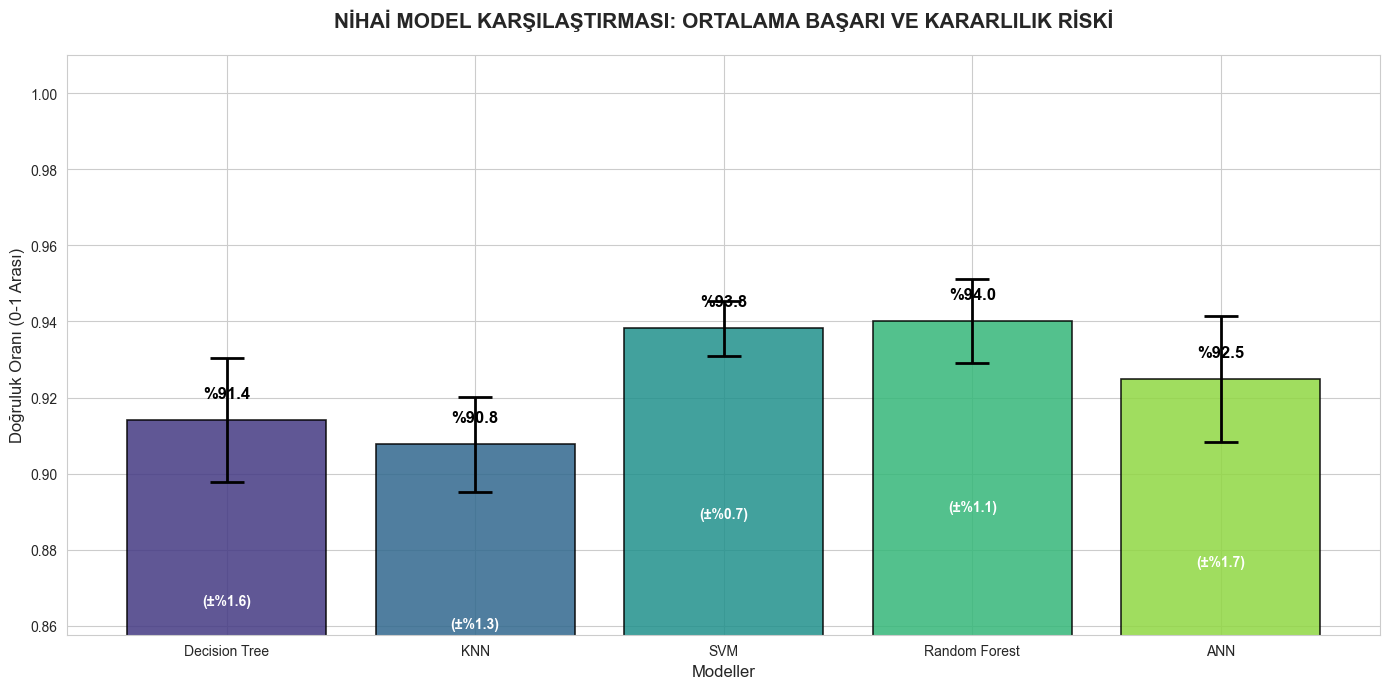


✅ Kararlılık testi tamamlandı. Siyah çizgi ne kadar kısaysa model o kadar güvenilirdir.


In [63]:
# --- 15. ADIM: K-KATLI ÇAPRAZ DOĞRULAMA (HATA ÇUBUKLU GRAFİK) ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

print("\n" * 2)
print("### 15. FİNAL KARARLILIK TESTİ (K-FOLD CROSS VALIDATION) ###")
print("-" * 110)
print("AMAÇ:   Modellerin başarısının 'şans eseri' olup olmadığını test etmek.")
print("YÖNTEM: Veri 10 parçaya bölünür. Sütun boyu 'Ortalama Başarıyı',")
print("        Siyah çizgiler (Hata Çubukları) ise 'Risk/Sapma' miktarını gösterir.")
print("-" * 110)

# Verileri Topla
means = []
stds = []
model_names = []
print(f"{'MODEL':<20} | {'ORTALAMA':<10} | {'SAPMA (RİSK)':<10}")
print("-" * 45)

for name, model in models.items():
    # 10 Katlı Doğrulama Yapılıyor
    scores = cross_val_score(model, X_train_sel, y_train, cv=10, scoring='accuracy')
    
    mean_val = scores.mean()
    std_val = scores.std()
    
    means.append(mean_val)
    stds.append(std_val)
    model_names.append(name)
    
    print(f"{name:<20} | %{mean_val*100:.2f}    | +/- %{std_val*100:.2f}")

# --- GÖRSELLEŞTİRME (HATA ÇUBUKLU SÜTUN) ---
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

# Renkler
colors = sns.color_palette('viridis', len(model_names))

# Grafiği Çiz (yerr=stds -> Siyah Hata Çizgisini Ekler)
# capsize=10 -> Hata çubuğunun tepesindeki şapka genişliği
bars = plt.bar(model_names, means, yerr=stds, capsize=12, color=colors, alpha=0.85, edgecolor='black', linewidth=1.2, error_kw=dict(lw=2, capthick=2))

plt.title('NİHAİ MODEL KARŞILAŞTIRMASI: ORTALAMA BAŞARI VE KARARLILIK RİSKİ', fontsize=15, fontweight='bold', pad=20)
plt.ylabel('Doğruluk Oranı (0-1 Arası)', fontsize=12)
plt.xlabel('Modeller', fontsize=12)

# Y Ekseni Aralığı (Farkların net görünmesi için alt limiti yukarı çekiyoruz)
min_score = min(means) - 0.05
plt.ylim(min_score, 1.01)

# Çubukların Üzerine Değerleri Yaz
for bar, mean_val, std_val in zip(bars, means, stds):
    yval = bar.get_height()
    # Ortalama Puan
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"%{mean_val*100:.1f}", 
             ha='center', va='bottom', fontweight='bold', fontsize=12, color='black')
    # Risk Puanı (İsteğe bağlı, sütunun içine yazılır)
    plt.text(bar.get_x() + bar.get_width()/2, yval - (yval*0.05), f"(±%{std_val*100:.1f})", 
             ha='center', va='top', fontsize=10, color='white', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Kararlılık testi tamamlandı. Siyah çizgi ne kadar kısaysa model o kadar güvenilirdir.")